In [3]:
from matplotlib import pyplot as plt
import os
from Library import *
from time import time
import dill
import re
import subprocess
import numpy as np
M = mathematica
from IPython.display import display, Math
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
from sympy import symbols, And, Piecewise, Add, N
from sympy.core.relational import Relational
from integration_functions import *
from fractions import Fraction as frac

t = sp.Symbol('t')

# computations originally done with notebooks in Mathematica/ directory, now automated with python
# limitation exists if list "bottoms" has 4 or more entries, need to add/modify code to handle that instance
def run_integrals(n_squares, index, a, perm):
    boundary_points = set()
    list_functions = []
    M('ClearAll["Global`*"]')
    totalVol = M('totalVol = 0')
    
    for j in range(len(a[0])):
        print(f"section {j}")
    
        with open(os.path.join("results", f"{n_squares}_{index}", f"secs_integrals_{j}.dill"), 'rb') as f:
            secs2 = dill.load(f)  
    
        subsections = format_subsections_for_mathematica(secs2)
    
        # Create directory for storing LaTeX outputs
        results_dir = os.path.join("results", f"{n_squares}_{index}", f"cusp_{j}")
        os.makedirs(results_dir, exist_ok=True)
    
        # LaTeX file path
        latex_file_path = os.path.join(results_dir, f"equations.tex")
        pdf_file_path = os.path.join(results_dir, f"equations.pdf")
    
        with open(latex_file_path, "w") as latex_file:
            # Start LaTeX document
            latex_file.write("\\documentclass{article}\n")
            latex_file.write("\\usepackage{amsmath}\n")
            latex_file.write("\\begin{document}\n\n")
    
            for i, subsection in enumerate(subsections):
                print(subsection)
                if len(subsection) == 5:
                    x0, y0, top, bottom1, left = subsection
                    bottoms = [bottom1]
                    points = []
                elif len(subsection) == 7:
                    x0, y0, top, bottom1, bottom2, point1, left = subsection
                    bottoms = [bottom1, bottom2]
                    points = [point1]
                elif len(subsection) == 9:
                    x0, y0, top, bottom1, bottom2, bottom3, point1, point2, left = subsection
                    bottoms = [bottom1, bottom2, bottom3]
                    points = [point1, point2]
    
                eqs, totalVol = integrals(x0, y0, top, bottoms, points, left)
    
                # Convert equation to LaTeX format
                expression_string = repr(eqs[1])
                # converting from Mathematica to sympy notation
                es, cs = parse_piecewise_sp(expression_string)
                print(f"cs orig: {cs}")
                for c in cs:
                    for c_ in c:
                        boundary_points.add(c_)

                # creating piecewise function to be saved as a dill file, the true equation
                eq_tuples = []
                for eq, cond in zip(es, cs):
                    # converting from Mathematica to sympy notation
                    cleaned_eq = (parse_expr(eq, local_dict={'t': t, 'sp': sp}), sp.And(sp.simplify(cond[0]) <= t, t < sp.simplify(cond[1])))
                    eq_tuples.append(cleaned_eq)

                # save equation in sympy format from mathematica format
                f = sp.Piecewise(*eq_tuples)
                with open(os.path.join(results_dir, f"equation_{i}.dill"), 'wb') as file:
                    dill.dump(f, file)

                # creating piecewise function for graphing, accounting for cutting off a bound of Infinity
                eq_tuples = []
                if cs[-1][1] == "Infinity":
                    cs[-1][1] = max(int(float(frac(cs[-1][0])) + 10), 20)
                    print(f"cs for graph: {cs}")
                    for eq, cond in zip(es, cs):
                        eq_tuples.append((
                            parse_expr(eq, local_dict={'t': t, 'sp': sp}),
                            sp.And(sp.simplify(cond[0]) <= t, t < sp.simplify(cond[1]))
                        ))
                    f_graph = sp.Piecewise(*eq_tuples)
                else:
                    f_graph = f
                
                list_functions.append(f)
                latex_expr = sp.latex(f)
                latex_expr = latex_expr.replace(r"\text{for}\: t", "").replace(r"\geq", "").replace(r"\wedge", r"\leq")
    
                # Write equation to LaTeX file
                latex_file.write(f"Equation {i}:\n\\[\n{latex_expr}\n\\]\n\n")
    
                # Generate graph for visualization
                graph_piece(f_graph, cs, n_squares, index, j, i)
    
            # End LaTeX document
            latex_file.write("\n\\end{document}\n")
    
        print(f"LaTeX file saved: {j}")
    
        # Compile the LaTeX file into a PDF while suppressing output
        try:
            with open(os.devnull, "w") as FNULL:
                subprocess.run(
                    ["pdflatex", "-output-directory", results_dir, latex_file_path],
                    stdout=FNULL, stderr=FNULL, check=True
                )
    
            print(f"PDF successfully created: {j}")
    
            # Remove auxiliary files (.log, .aux)
            for ext in [".log", ".aux"]:
                aux_file = os.path.join(results_dir, f"equations{ext}")
                if os.path.exists(aux_file):
                    os.remove(aux_file)
    
        except subprocess.CalledProcessError:
            print(f"Error: Failed to compile {j} into a PDF.")

    # Open the file in write mode
    # symbolic version
    # totalVol is a global variable that is added to with every call to "integrals"
    totalVol = M('totalVol = FullSimplify[totalVol]')
    # numeric version
    totalVol2 = M('totalVolN = N[totalVol]')

    # expected coVolume
    veech_index = int(re.findall(r'index (\d+)', str(perm.veech_group()))[0])
    # numeric
    target = M(f'target = N[(Pi^2/6)*{veech_index}]')
    save_path = os.path.join("results", f"{n_squares}_{index}", "coVolume.txt")
    with open(save_path, "w") as file:
        file.write(f"{totalVol}\n\n\n")
        file.write(f"rounded coVol: {totalVol2}\n")
        file.write(f"rounded target: {target}\n")
    boundary_points = [sp.Symbol("Infinity") if bp == "Infinity" else sp.simplify(bp) for bp in boundary_points]
    sorted_numbers = sorted(boundary_points, key=lambda x: float(x) if x != sp.Symbol("Infinity") else float('inf'))

    with open(os.path.join("results", f"{n_squares}_{index}", "piecewise_list.dill"), 'wb') as f:
        dill.dump(list_functions, f)

    with open(os.path.join("results", f"{n_squares}_{index}", "boundary_points.dill"), 'wb') as f:
        dill.dump(sorted_numbers, f)
    
    return list_functions, sorted_numbers

def create_combined_piecewise(piecewise_list, boundary_points):
    combined_piecewise = []
    combined_scaled_piecewise = []
    # variable that keeps tracks of how many times theres a non-zero function 
    # contributing to the interval starting at 1, (usually the interval [1,2]). 
    # Used to scale the final pdf to compare across other shapes
    count = 0

    for i in range(len(boundary_points) - 1):
        lower_bound = boundary_points[i]
        upper_bound = boundary_points[i + 1]
        print(lower_bound, upper_bound)

        # Create the condition for the current interval
        interval_condition = (t >= lower_bound) & (t < upper_bound)
        if upper_bound == sp.Symbol("Infinity"):
            interval_condition = (t >= lower_bound) & (t < sp.oo)
        
        # Find all equations active in this interval
        active_equations = []
        for pw in piecewise_list:
            for expr, cond in pw.args:
                # convert Mathematica representation of infinity to sympys version for later computations
                if cond.args[1] == sp.StrictGreaterThan(sp.Symbol("Infinity"), t):
                    cond = sp.And(cond.args[0], sp.StrictLessThan(t, sp.oo))
                
                # Check if the interval is fully contained within the condition
                if sp.simplify(And(interval_condition, cond)) == interval_condition:
                    if lower_bound == 1 and expr != 0:
                        count += 1
                    active_equations.append(expr)      

        # Add the active equations together
        combined_expression = Add(*active_equations)
        combined_piecewise.append((combined_expression, interval_condition))
        # ignore interval from [0,1] so there is no division by zero error
        if count == 0:
            combined_scaled_piecewise.append((combined_expression, interval_condition))
        else:
            combined_scaled_piecewise.append((combined_expression/count, interval_condition))

    # Create the final combined Piecewise function
    return Piecewise(*combined_piecewise), Piecewise(*combined_scaled_piecewise)

# sets up a list of strings to feed into mathematica for information on the subsection with the following info:
# input is a poincare section, output is a list of string representations for each subsection
def format_subsections_for_mathematica(section):
    outputs = []
    for subsection in section:
        output = []
        output.append("x0 = " + str(subsection.vec[0][0]))
        output.append("y0 = " + str(subsection.vec[1][0]))
        output.append("top = " + str(subsection.top[0]))
        for i in range(len(subsection.bottom)):
            output.append("bottom" + str(i+1) + " = " + str(subsection.bottom[i]))
        for i in range(len(subsection.points_bottom)):
            if i == 0:
                continue
            output.append("point" + str(i) + " = " + str(subsection.points_bottom[i]))
        output.append("left = " + str(subsection.points_bottom[0]))
        outputs.append(output)
    return outputs

# this code is not used but a clearer reference for a smple of what the integrals function computes.
# this is for subsections with only 1 bottom equation so work to decide certain things about the section is not included

# x0 is the x-component of the winning saddle
# y0 is the y-component of the winning saddle
# top is the equation of the top part of the section
# bottom1 is the equation of the bottom1 part of the section (assumes only one bottom equation for simplicity)
# left is the left-most point of the section

def nb_1(x0, y0, top, bottom1, left):
    M('ClearAll["Global`*"]')
    x0 = M(f'x0 = {x0}')
    y0 = M(f'y0 = {y0}')
    top = M(f'top = {top}')
    bottom1 = M(f'bottom1 = {bottom1}')
    left = M(f'left = {left}')
    func = M('func = 1/(t*x) - x0/y0*x')
    # the time when the parabala enters the section is always equal to y0 (always the top right point)
    timeEnter = M('timeEnter = t /. Solve[y0 - t == 0, t][[1]]')
    symbolicZeros = M('symbolicZeros = Solve[bottom1 - func == 0, x]')
    #left-most x-coordinate where parabola intersects bottom after intial intersection
    r1 = M('r1 = x /. symbolicZeros[[1]]')
    #right-most x-coordinate where parabola intersects bottom after intial intersection
    r2 = M('r2 = x /. symbolicZeros[[2]]')
    # time when the parabola hits the bottom line
    timeEdge = M(' timeEdge = t /. Solve[r2 - r1 == 0, t][[1]]')
    try:
        tR = M('tR = t /. Solve[r2 - 1 == 0, t][[1]]')
    except:
        tR = None
    
    try:
        tL = M('tL = t /. Solve[r1 - left == 0, t][[1]]')
    except:
        tL = None

    # intersection 
    try:
        tRA = M('tRA = t /. Solve[r1 - 1 == 0, t][[1]]')
    except:
        tRA = None
    
    try:
        tLA = M('tLA = t /. Solve[r2 - left == 0, t][[1]]')
    except:
        tLA = None
    
    #print(f"time Right End = {tR}")
    #print(f"time Left End = {tL}")
    #print()
    #print(f"Right Alt = {tRA}")
    #print(f"Left Alt = {tLA}")
    
    if tR is None and tRA is None:
        #placefolder for infinity, used infinity to actual code
        tR = M('tR = 20')
    if tL is None and tLA is None:
        #placeholder for infinity, used infinity to actual code
        tL = M('tL = 20')
    
    if tR is None and tRA is not None:
        tR = M('tR = tRA')
        timeEdge = M('timeEdge = tR')
    if tL is None and tLA is not None:
        tL = M('tL = tLA')
        timeEdge = M('timeEdge = tL')

    #print()
    #print(f"new Right End = {tR}")
    #print(f"new Left End = {tL}")
    #print(f"Edge = {timeEdge}")

    try:
        f1 = M('f1 = Simplify[D[Integrate[1, {x, y0/t, 1}, {y, func, top}], t]]')
    except:
        f1 = -1
    try:
        f2 = M('f2 = Simplify[f1 - Simplify[D[Integrate[1, {x, r1, r2}, {y, func, bottom1}], t]]]')
    except: 
        f2 = -1
    try:
        f3 = M('f3 = Simplify[f1 - Simplify[D[Integrate[1, {x, r1, 1}, {y, func, bottom1}], t]]]')
    except:
        f3 = -1
    try:
        fL = M('fL = Simplify[D[Integrate[1, {x, left, 1}, {y, func, top}], t]]')
    except:
        fL = -1
    try:
        f4 = M('f4 = Simplify[fL - Simplify[D[Integrate[1, {x, left, r2}, {y, func, bottom1}], t]]]')
    except:
        f4 = -1
    
    combined = M('combined = Piecewise[{{0, 0 <= t < timeEnter},{f1, timeEnter <= t < timeEdge},{f2, timeEdge <= t < Min[tR, tL]},{f3, tR <= t < tL},{f4, tL <= t < tR},{0, Max[tR, tL] <= t < 20}}]')
    eqs = M('Normal @ combined')

    return eqs

def parse_piecewise_sp(expression_string):
    # Convert Mathematica syntax to Python syntax for sympy
    expression_string = expression_string.replace('Log', 'sp.log').replace('Sqrt', 'sp.sqrt')
    expression_string = expression_string.replace("ArcTanh", "sp.atanh").replace("ArcCosh", "sp.acosh").replace("ArcSinh", "sp.asinh")
    expression_string = expression_string.replace("ArcCoth", "sp.acoth").replace("ArcSech", "sp.asech").replace("ArcCosecanth", "sp.acsch")

    # Extract individual pieces
    pieces = re.findall(r'\{(.*?),\s*Inequality\[(.*?)\]\}', expression_string, re.DOTALL)
    
    conditions = []
    expressions = []
    
    for expr, ineq in pieces:
        expr = expr.strip()
        expr = expr.replace("\n", "").replace("[", "(").replace("]", ")").replace("^", "**")
        ineq = ineq.replace("\n", "").strip()
        ineq = ineq.replace('LessEqual', '<=').replace('Less', '<').replace(',', ' and t ')  # Convert inequality format
        ineq = re.sub(r"\s*and\s*t\s*<=\s*and\s*t\s*t\s*and\s*t\s*<\s*and\s*t\s*", ",", ineq)
        ineq = ineq.split(",")
        
        conditions.append([ineq[0], ineq[1]])
        expressions.append(expr)
    expressions[0] = '0'

    # if float(frac(conditions[-1][1])) < 20:
    #     conditions.append([conditions[-1][1], 20])
    #     expressions.append("0")
    
    return expressions, conditions

def graph_piece(f, cs, n_squares, index, j, i):
    #print(cs)
    # Define symbolic variable
    t = sp.Symbol('t')
    
    # Suppress warnings
    np.seterr(divide='ignore', invalid='ignore')
    
    # Generate values for plotting using `f.subs()`
    t_vals = np.linspace(0, float(frac(cs[-1][1])), 1000)  # Define t from 0 to 20

    #print(f)
    # Evaluate function at each point using `.subs()`
    y_vals = np.array([f.subs(t, val).evalf() for val in t_vals])  # Convert to numeric
    
    # Plot the function
    plt.plot(t_vals, y_vals, label=r"$PDF$", color="b")
    
    # Compute transition points
    non_diff_set = set()
    for c in cs[:-1]:
        for c_ in c:
            non_diff_set.add(float(frac((c_))))  # Convert fractions if needed
    #print(non_diff_set)
    
    transition_x = np.array(list(non_diff_set))
    transition_y = np.array([f.subs(t, val-0.005).evalf() for val in transition_x])  # Compute y-values
    
    plt.scatter(transition_x, transition_y, color="red", zorder=3, label="Points", s = 10)
    plt.scatter(0, 0, color="red", zorder=3, label="Points", s = 10)
    
    # Formatting
    plt.xticks(np.arange(0, float(frac(cs[-1][1])), 2))  # Ticks from 0 to 20 with step size of 2
    plt.xlabel("t")
    plt.title("PDF_label")
    plt.grid()
    plt.legend()
    
    # Show plot
    if j != -1:
        save_path = os.path.join("results", f"{n_squares} - {index}", f"cusp - {j}")
        os.makedirs(save_path, exist_ok=True)
        # Save the plot
        plt.savefig(os.path.join(save_path, f"test_graph - {i}.png"))
    else:
        save_path = os.path.join("results", f"{n_squares} - {index}", f"test_Final_graph.png")
        plt.savefig(save_path)
    
    # Show the plot
    plt.show()
    
    # Clear the figure to avoid overlapping plots in future calls
    plt.clf()

def integrals(x0, y0, top, bottoms, points, left):
    #M('ClearAll["Global`*"]')

    x0 = M(f"{x0}")
    y0 = M(f"{y0}")
    
    top = M(f"{top}")
    
    bottom1 = M(f"{bottoms[0]}")
    try:
        bottom2 = M(f"{bottoms[1]}")
    except:
        bottom2 = None
    try:
        bottom3 = M(f"{bottoms[2]}")
    except:
        bottom3 = None
        
    try:
        point1 = M(f"{points[0]}")
    except:
        point1 = None
    try:
        point2 = M(f"{points[1]}")
    except:
        point2 = None
        
    left = M(f"{left}")
    
    func = M('func = 1/(t*x) - x0/y0*x')
    funct = M('funct = y0/(x*(x0*x + y0*y))')
    
    if bottom2 is None:
        point1 = M('point1 = 1')
    elif bottom3 is None:
        point2 = M('point2 = 1')
    
    symbolicZeros = M('symbolicZeros = Solve[bottom1 - func == 0, x]')
    l1 = M('l1 = x /. symbolicZeros[[1]]')
    l2 = M('l2 = x /. symbolicZeros[[2]]')
    
    if bottom2 is not None:
        symbolicZeros = M('symbolicZeros = Solve[bottom2 - func == 0, x]')
        m1 = M('m1 = x /. symbolicZeros[[1]]')
        m2 = M('m2 = x /. symbolicZeros[[2]]')
    
    if bottom3 is not None:
        symbolicZeros = M('symbolicZeros = Solve[bottom3 - func == 0, x]')
        r1 = M('r1 = x /. symbolicZeros[[1]]')
        r2 = M('r2 = x /. symbolicZeros[[2]]')
    
    if bottom1 is not None and bottom2 is not None and bottom3 is not None:
        expressions = {
            "timeEnter": 'timeEnter = t /. Solve[y0 - t == 0, t][[1]]',
            "timeLeftEnd": 'timeLeftEnd = t /. Solve[l1 - left == 0, t][[1]]',
            "timeBottom1": 'timeBottom1 = t /. Solve[l2 - l1 == 0, t][[1]]',
            "timePoint1": 'timePoint1 = t /. Solve[l2 == m1, t][[1]]',
            "timeBottom2": 'timeBottom2 = t /. Solve[m2 - m1 == 0, t][[1]]',
            "timePoint2": 'timePoint2 = t /. Solve[m2 == r1, t][[1]]',
            "timeBottom3": 'timeBottom3 = t /. Solve[r2 - r1 == 0, t][[1]]',
            "timeRightEnd": 'timeRightEnd = t /. Solve[r2 - 1 == 0, t][[1]]',
            "timeLeftEndA": 'timeLeftEndA = t /. Solve[l2 - left == 0, t][[1]]',
            "timeRightEndA": 'timeRightEndA = t /. Solve[r1 - 1 == 0, t][[1]]',
            "timePoint1A": 'timePoint1A = t /. Solve[l2 == m2, t][[1]]',
            "timePoint1B": 'timePoint1B = t /. Solve[l1 == m1, t][[1]]',
            "timePoint2A": 'timePoint2A = t /. Solve[m2 == r2, t][[1]]',
            "timePoint2B": 'timePoint2B = t /. Solve[m1 == r1, t][[1]]'
        }
    
        results = {}
        for key, expr in expressions.items():
            try:
                results[key] = (M(expr))
                print(f'{key}: {results[key]}')
            except Exception:
                results[key] = None
                print(f'{key}: None')
        
        # Unpacking the results if you still want individual variables
        (timeEnter, timeLeftEnd, timeBottom1, timePoint1,
         timeBottom2, timePoint2, timeBottom3, timeRightEnd, timeLeftEndA, timeRightEndA, timePoint1A, timePoint1B, timePoint2A, timePoint2B) = results.values()

        #print(timeEnter, timeLeftEnd, timeBottom1, timePoint1, timeBottom2, timePoint2, timeBottom3, timeRightEnd, timeLeftEndA, timeRightEndA)
        
        if timeRightEnd is None and timeRightEndA is None:
            timeRightEnd = M('timeRightEnd = Infinity')
        if timeLeftEnd is None and timeLeftEndA is None and timePoint1B is None:
            timeLeftEnd = M('timeLeftEnd = Infinity')
        if timePoint1 is None and timePoint1A is None:
            timePoint1 = M('timePoint1 = Infinity')
        if timePoint2 is None and timePoint2A is None and timePoint2B is None:
            timePoint2 = M('timePoint2 = Infinity')
        
        if timeRightEnd is None and timeRightEndA is not None:
            timeRightEnd = M('timeRightEnd = timeRightEndA')
            timeBottom3 = M('timeBottom3 = timeRightEnd')
            results['timeRightEnd'] = timeRightEndA
            results['timeBottom3'] = timeRightEndA
        if timeLeftEnd is None and timeLeftEndA is not None:
            timeLeftEnd = M('timeLeftEnd = timeLeftEndA')
            timeBottom1 = M('timeBottom1 = timeLeftEnd')
            results['timeLeftEnd'] = timeLeftEndA
            results['timeBottom1'] = timeLeftEndA
        # check logic
        if timePoint1 is None and timePoint1A is not None:
            timePoint1 = M('timePoint1 = timePoint1A')
            timeBottom2 = M('timeBottom2 = timePoint1')
            results['timePoint1'] = timePoint1A
            results['timeBottom2'] = timePoint1A
        # check logic
        if timePoint1 is None and timePoint1B is not None:
            timePoint1 = M('timePoint1 = timePoint1B')
            timeBottom1 = M('timeBottom1 = timePoint1')
            results['timePoint1'] = timePoint1B
            results['timeBottom1'] = timePoint1B
        # check logic
        if timePoint2 is None and timePoint2A is not None:
            timePoint2 = M('timePoint2 = timePoint2A')
            timeBottom3 = M('timeBottom3 = timePoint2')
            results['timePoint2'] = timePoint2A
            results['timeBottom3'] = timePoint2A
        # check logic
        if timePoint2 is None and timePoint2B is not None:
            timePoint2 = M('timePoint2 = timePoint2B')
            timeBottom2 = M('timeBottom2 = timePoint2')
            results['timePoint2'] = timePoint2B
            results['timeBottom2'] = timePoint2B

        new_vals = [timeEnter, timeLeftEnd, timeBottom1, timePoint1, timeBottom2, timePoint2, timeBottom3, timeRightEnd, timeLeftEndA, timeRightEndA, timePoint1A, timePoint2A]
        # for val in new_vals:
        #     try:
        #         print(float(val))
        #     except:
        #         print(val)
                
    elif bottom1 is not None and bottom2 is not None and bottom3 is None:
        expressions = {
            "timeEnter": 'timeEnter = t /. Solve[y0 - t == 0, t][[1]]',
            "timeLeftEnd": 'timeLeftEnd = t /. Solve[l1 - left == 0, t][[1]]',
            "timeBottom1": 'timeBottom1 = t /. Solve[l2 - l1 == 0, t][[1]]',
            "timePoint1": 'timePoint1 = t /. Solve[l2 == m1, t][[1]]',
            "timeBottom2": 'timeBottom2 = t /. Solve[m2 - m1 == 0, t][[1]]',
            "timePoint2": 'timePoint2 = t /. Solve[m2 - 1 == 0, t][[1]]',
            "timeLeftEndA": 'timeLeftEndA = t /. Solve[l2 - left == 0, t][[1]]',
            "timePoint2A": 'timePoint2A = t /. Solve[m1 - 1 == 0, t][[1]]',
            "timePoint1A": 'timePoint1 = t /. Solve[l2 == m2, t][[1]]',
            "timePoint1B": 'timePoint1 = t /. Solve[l1 == m1, t][[1]]'
        }
    
        results = {}
        for key, expr in expressions.items():
            try:
                results[key] = (M(expr))
                print(f'{key}: {results[key]}')
            except Exception:
                results[key] = None
                print(f'{key}: None')
        
        # Unpacking the results if you still want individual variables
        (timeEnter, timeLeftEnd, timeBottom1, timePoint1,
         timeBottom2, timePoint2, timeLeftEndA, timePoint2A, timePoint1A, timePoint1B) = results.values()

        #print(timeEnter, timeLeftEnd, timeBottom1, timePoint1, timeBottom2, timePoint2, timeLeftEndA, timePoint2A)
        
        if timePoint2 is None and timePoint2A is None:
            timePoint2 = M('timePoint2 = Infinity')
        if timeLeftEnd is None and timeLeftEndA is None:
            timeLeftEnd = M('timeLeftEnd = Infinity')
        if timePoint1 is None and timePoint1A is None:
            timePoint1 = M('timePoint1 = Infinity')
            
        if timePoint2 is None and timePoint2A is not None:
            timePoint2 = M('timePoint2 = timePoint2A')
            timeBottom2 = M('timeBottom2 = timePoint2A')
            results['timePoint2'] = timePoint2A
            results['timeBottom2'] = timePoint2A
        if timeLeftEnd is None and timeLeftEndA is not None:
            timeLeftEnd = M('timeLeftEnd = timeLeftEndA')
            timeBottom1 = M('timeBottom1 = timeLeftEnd')
            results['timeLeftEnd'] = timeLeftEndA
            results['timeBottom1'] = timeLeftEndA
        # check logic
        if timePoint1 is None and timePoint1A is not None:
            timePoint1 = M('timePoint1 = timePoint1A')
            timeBottom2 = M('timeBottom2 = timePoint1')
            results['timePoint1'] = timePoint1A
            results['timeBottom2'] = timePoint1A
        # check logic
        if timePoint1 is None and timePoint1B is not None:
            timePoint1 = M('timePoint1 = timePoint1B')
            timeBottom1 = M('timeBottom1 = timePoint1')
            results['timePoint1'] = timePoint1B
            results['timeBottom1'] = timePoint1B

        new_vals = [timeEnter, timeLeftEnd, timeBottom1, timePoint1, timeBottom2, timePoint2, timeLeftEndA, timePoint2A, timePoint1A]
        # for val in new_vals:
        #     try:
        #         #print(float(val))
        #     except:
        #         #print(val)
    
    elif bottom1 is not None and bottom2 is None and bottom3 is None:
        expressions = {
            "timeEnter": 'timeEnter = t /. Solve[y0 - t == 0, t][[1]]',
            "timeLeftEnd": 'timeLeftEnd = t /. Solve[l1 - left == 0, t][[1]]',
            "timeBottom1": 'timeBottom1 = t /. Solve[l2 - l1 == 0, t][[1]]',
            "timePoint1": 'timeRightEnd = t /. Solve[l2 - 1 == 0, t][[1]]',
            "timeLeftEndA": 'timeLeftEndA = t /. Solve[l2 - left == 0, t][[1]]',
            "timePoint1A": 'timePoint1A = t /. Solve[l1 - 1 == 0, t][[1]]'
        }
    
        results = {}
        for key, expr in expressions.items():
            try:
                results[key] = (M(expr))
                print(f'{key}: {results[key]}')
            except Exception:
                results[key] = None
                print(f'{key}: None')
        
        # Unpacking the results if you still want individual variables
        (timeEnter, timeLeftEnd, timeBottom1, timePoint1, timeLeftEndA, timePoint1A) = results.values()

        #print(timeEnter, timeLeftEnd, timeBottom1, timePoint1, timeLeftEndA, timePoint1A)
        
        if timePoint1 is None and timePoint1A is None:
            timePoint1 = M('timePoint1 = Infinity')
        if timeLeftEnd is None and timeLeftEndA is None:
            timeLeftEnd = M('timeLeftEnd = Infinity')

        if timePoint1 is None and timePoint1A is not None:
            timePoint1 = M('timePoint1 = timePoint1A')
            timeBottom1 = M('timeBottom1 = timePoint1')
            results['timePoint1'] = timePoint1A
            results['timeBottom1'] = timePoint1A
        if timeLeftEnd is None and timeLeftEndA is not None:
            timeLeftEnd = M('timeLeftEnd = timeLeftEndA')
            timeBottom1 = M('timeBottom1 = timeLeftEnd')
            results['timeLeftEnd'] = timeLeftEndA
            results['timeBottom1'] = timeLeftEndA

        new_vals = [timeEnter, timeLeftEnd, timeBottom1, timePoint1, timeLeftEndA, timePoint1A]
        # for val in new_vals:
        #     try:
        #         #print(float(val))
        #     except:
        #         #print(val)
    else:
        raise ValueError("section defined improperly")
    
    try:
        f1 = M('f1 = Simplify[D[Integrate[1, {x, y0/t, 1}, {y, func, top}], t]]')
    except:
        f1 = -1
    try:
        fL = M('fL = Simplify[D[Integrate[1, {x, left, 1}, {y, func, top}], t]]')
    except:
        fL = -1
        #print("no fL")
    
    nums = set()
    for key in results.keys():
        num = results[key]
        if num is None:
            continue
        nums.add(num)
    nums = sorted(list(nums))
    
    #print()
    
    function_strings = []
    function_strings.append(0)
    for num in nums:
        function_string = list('000$000$000')  # Convert string to list for mutability
        
        if timeLeftEnd <= num:
            function_string[0] = '1'
        if timeBottom1 <= num:
            function_string[1] = '1'
        if timePoint1 <= num:
            function_string[2:5] = list('1$1')  # Assign list to preserve underscore
        if bottom2 is not None:
            if timeBottom2 <= num:
                function_string[5] = '1'
            if timePoint2 <= num:
                function_string[6:9] = list('1$1')  # Assign list
        if bottom3 is not None:
            if timeBottom3 <= num:
                function_string[9] = '1'
            if timeRightEnd <= num:
                function_string[10] = '1'
    
        if bottom2 is None:
            function_string[4:] = '000$000'
        elif bottom3 is None:
            #print("true")
            function_string[8:] = '000'
        function_string = ''.join(function_string)  # Convert list back to string
        function_strings.append("f$" + function_string)
    function_strings[1] = "f1"
    
    equations = []
    for function in function_strings[2:]:
        print(function)
        eq = M(f"{equations_dict[function]}")
        equations.append(eq)
        
    nums.append(0)
    nums = sorted(nums)
    combined_string = 'combined = Piecewise[{'
    for i in range(len(function_strings)):
        t0 = nums[i]
        # make string representations of fractional times consistent
        t0 = re.sub(r"\s*-+\s*", "|", str(t0)).strip()
        # same thing but if t1 is infinity, it will throw an error
        try:
            t1 = nums[i+1]
            t1 = re.sub(r"\s*-+\s*", "|", str(t1)).strip()
        except:
            # if parabola has exited the section, dont need to add any more to the piecewise equation
            if function_strings[i] == "f$111$000$000" or function_strings[i] == "f$111$111$000" or function_strings[i] == "f$111$111$111":
                break
            t1 = "Infinity"
        combined_string = combined_string + f"/{{{function_strings[i]}, {t0} <= t < {t1}}},"
    # remove comma at the end of string
    combined_string = combined_string[:-1]
    # add closing brackets
    combined_string = combined_string + "}]"
    # fix string representations and make fractions properly
    combined_string = combined_string.replace("/", "")
    combined_string = combined_string.replace("|", "/")
    print(combined_string)
    
    combined = M(f"{combined_string}")
    eqs = M('Normal @ combined')

    # CoVolume Calculations
    # totalVol is a global variable that is not reset between function calls among sections and subsections. totalVol will be the cumalitive CoVolume for the entire STS after running this fuinction for all cusps and will be the coVolume of the shape
    if bottom3 is not None:
        b1Co = M('b1Co = Integrate[funct, {x, left, point1}, {y, bottom1, top}]')
        b2Co = M('b2Co = Integrate[funct, {x, point1, point2}, {y, bottom2, top}]')
        b3Co = M('b3Co = Integrate[funct, {x, point2, 1}, {y, bottom3, top}]')
        totalVol = M('totalVol = totalVol + b1Co + b2Co + b3Co')
    elif bottom2 is not None:
        b1Co = M('b1Co = Integrate[funct, {x, left, point1}, {y, bottom1, top}]')
        b2Co = M('b2Co = Integrate[funct, {x, point1, point2}, {y, bottom2, top}]')
        totalVol = M('totalVol = totalVol + b1Co + b2Co')
    elif bottom1 is not None:
        b1Co = M('b1Co = Integrate[funct, {x, left, point1}, {y, bottom1, top}]')
        totalVol = M('totalVol = totalVol + b1Co')

    #print(totalVol)

    return eqs, totalVol

In [60]:
def run_integrals(n_squares, index, a, perm):
    boundary_points = set()
    list_functions = []
    M('ClearAll["Global`*"]')
    totalVol = M('totalVol = 0')
    
    for j in range(len(a[0])):
        print(f"section {j}")
    
        # with open(os.path.join("results", f"{n_squares}_{index}", f"secs_integrals_{j}.dill"), 'rb') as f:
        #     secs2 = dill.load(f)  
        with open(os.path.join("results", f"{n_squares} - {index}", f"secs_integrals - {j}.dill"), 'rb') as f:
            secs2 = dill.load(f)  
    
        subsections = format_subsections_for_mathematica(secs2)
    
        # Create directory for storing LaTeX outputs
        #results_dir = os.path.join("results", f"{n_squares}_{index}", f"cusp_{j}")
        results_dir = os.path.join("results", f"{n_squares} - {index}", f"cusp - {j}")
        os.makedirs(results_dir, exist_ok=True)
    
        # LaTeX file path
        latex_file_path = os.path.join(results_dir, f"test_equations.tex")
        pdf_file_path = os.path.join(results_dir, f"test_equations.pdf")
    
        with open(latex_file_path, "w") as latex_file:
            # Start LaTeX document
            latex_file.write("\\documentclass{article}\n")
            latex_file.write("\\usepackage{amsmath}\n")
            latex_file.write("\\begin{document}\n\n")

            for i, subsection in enumerate(subsections):
                print(subsection)
                x0 = subsection["x0"]
                y0 = subsection["y0"]
                top = subsection["top"]
                bottoms = subsection["bottoms"]
                points = subsection["points"]
                left = subsection["left"]
    
                eqs, totalVol = integrals(x0, y0, top, bottoms, points, left)
        
                # Convert equation to LaTeX format
                expression_string = repr(eqs[1])
                # converting from Mathematica to sympy notation
                es, cs = parse_piecewise_sp(expression_string)
                print(f"cs orig: {cs}")
                for c in cs:
                    for c_ in c:
                        boundary_points.add(c_)
    
                # creating piecewise function to be saved as a dill file, the true equation
                eq_tuples = []
                for eq, cond in zip(es, cs):
                    # converting from Mathematica to sympy notation
                    cleaned_eq = (parse_expr(eq, local_dict={'t': t, 'sp': sp}), sp.And(sp.simplify(cond[0]) <= t, t < sp.simplify(cond[1])))
                    eq_tuples.append(cleaned_eq)
    
                # save equation in sympy format from mathematica format
                f = sp.Piecewise(*eq_tuples)
                # with open(os.path.join(results_dir, f"equation_{i}.dill"), 'wb') as file:
                #     dill.dump(f, file)
                with open(os.path.join(results_dir, f"test_equation_{i}.dill"), 'wb') as file:
                    dill.dump(f, file)
    
                # creating piecewise function for graphing, accounting for cutting off a bound of Infinity
                eq_tuples = []
                if cs[-1][1] == "Infinity":
                    cs[-1][1] = str(max(int(float(frac(cs[-1][0])) + 10), 20))
                    print(f"cs for graph: {cs}")
                    for eq, cond in zip(es, cs):
                        eq_tuples.append((
                            parse_expr(eq, local_dict={'t': t, 'sp': sp}),
                            sp.And(sp.simplify(cond[0]) <= t, t < sp.simplify(cond[1]))
                        ))
                    f_graph = sp.Piecewise(*eq_tuples)
                else:
                    f_graph = f
                
                list_functions.append(f)
                latex_expr = sp.latex(f)
                latex_expr = latex_expr.replace(r"\text{for}\: t", "").replace(r"\geq", "").replace(r"\wedge", r"\leq")
    
                # Write equation to LaTeX file
                latex_file.write(f"Equation {i}:\n\\[\n{latex_expr}\n\\]\n\n")
    
                # Generate graph for visualization
                graph_piece(f_graph, cs, n_squares, index, j, i)
        
            # End LaTeX document
            latex_file.write("\n\\end{document}\n")
    
        print(f"LaTeX file saved: {j}")
    
        # Compile the LaTeX file into a PDF while suppressing output
        try:
            with open(os.devnull, "w") as FNULL:
                subprocess.run(
                    ["pdflatex", "-output-directory", results_dir, latex_file_path],
                    stdout=FNULL, stderr=FNULL, check=True
                )
    
            print(f"PDF successfully created: {j}")
    
            # Remove auxiliary files (.log, .aux)
            for ext in [".log", ".aux"]:
                aux_file = os.path.join(results_dir, f"test_equations{ext}")
                if os.path.exists(aux_file):
                    os.remove(aux_file)
    
        except subprocess.CalledProcessError:
            print(f"Error: Failed to compile {j} into a PDF.")

    # Open the file in write mode
    # symbolic version
    # totalVol is a global variable that is added to with every call to "integrals"
    totalVol = M('totalVol = FullSimplify[totalVol]')
    # numeric version
    totalVol2 = M('totalVolN = N[totalVol]')

    # expected coVolume
    veech_index = int(re.findall(r'index (\d+)', str(perm.veech_group()))[0])
    # numeric
    target = M(f'target = N[(Pi^2/6)*{veech_index}]')
    save_path = os.path.join("results", f"{n_squares} - {index}", "test_coVolume.txt")
    with open(save_path, "w") as file:
        file.write(f"{totalVol}\n\n\n")
        file.write(f"rounded coVol: {totalVol2}\n")
        file.write(f"rounded target: {target}\n")
    boundary_points = [sp.Symbol("Infinity") if bp == "Infinity" else sp.simplify(bp) for bp in boundary_points]
    sorted_numbers = sorted(boundary_points, key=lambda x: float(x) if x != sp.Symbol("Infinity") else float('inf'))

    with open(os.path.join("results", f"{n_squares} - {index}", "test_piecewise_list.dill"), 'wb') as f:
        dill.dump(list_functions, f)

    with open(os.path.join("results", f"{n_squares} - {index}", "test_boundary_points.dill"), 'wb') as f:
        dill.dump(sorted_numbers, f)
    
    return list_functions, sorted_numbers

In [61]:
def format_subsections_for_mathematica(section):
    outputs = []
    for subsection in section:
        output = {}
        output["bottoms"] = []
        output["points"] = []
        output["x0"] = "x0 = " + str(subsection.vec[0][0])
        output["y0"] = "y0 = " + str(subsection.vec[1][0])
        output["top"] = "top = " + str(subsection.top[0])
        for i in range(len(subsection.bottom)):
            output["bottoms"].append("bottom" + str(i+1) + " = " + str(subsection.bottom[i]))
        for i in range(len(subsection.points_bottom)):
            if i == 0:
                continue
            output["points"].append("point" + str(i) + " = " + str(subsection.points_bottom[i]))
        output["left"] = "left = " + str(subsection.points_bottom[0])
        outputs.append(output)
    return outputs

In [62]:
def integrals(x0, y0, top, bottoms, points, left):
    # dictionary to hold values for section
    values = {}
    #M('ClearAll["Global`*"]')

    values["x0"] = M(f"{x0}")
    values["y0"] = M(f"{y0}")
    
    values["top"] = M(f"{top}")

    for i in range(len(bottoms)):
        values[f"bottom{i+1}"] = M(f"{bottoms[i]}")
    for i in range(len(points)):
        values[f"point{i+1}"] = M(f"{points[i]}") 
    values[f"point0"] = M(f"point0 = {left}")
    values[f"point{len(points)+1}"] = M(f"point{len(points)+1} = 1")
        
    left = M(f"{left}")
    
    func = M('func = 1/(t*x) - x0/y0*x')
    funct = M('funct = y0/(x*(x0*x + y0*y))')

    print(values)
    expressions = {}
    expressions["timeEnter"] = 'timeEnter = t /. Solve[y0 - t == 0, t][[1]]'
    for i in range(1, len(bottoms) + 1):
        symbolicZeros = M(f'symbolicZeros = Solve[bottom{i} - func == 0, x]')
        values[f"inter{i}$1"] = M(f'inter{i}$1 = x /. symbolicZeros[[1]]')
        values[f"inter{i}$2"] = M(f'inter{i}$2 = x /. symbolicZeros[[2]]')
        if i == 1:
            expressions["timePoint0"] = 'timePoint0 = t /. Solve[inter1$1 == left, t][[1]]'
            expressions["timePoint0A"] = 'timePoint0A = t /. Solve[inter1$2 == left, t][[1]]'
        if i != len(bottoms):
            expressions[f"timePoint{i}"] = f'timePoint{i} = t /. Solve[inter{i}$2 == inter{i+1}$1, t][[1]]'
            expressions[f"timePoint{i}A"] = f'timePoint{i}A = t /. Solve[inter{i}$2 == inter{i+1}$2, t][[1]]'
            expressions[f"timePoint{i}B"] = f'timePoint{i}B = t /. Solve[inter{i}$1 == inter{i+1}$1, t][[1]]'
        else:
            expressions[f"timePoint{i}"] = f'timePoint{i} = t /. Solve[inter{i}$2 == 1, t][[1]]'
            expressions[f"timePoint{i}A"] = f'timePoint{i}A = t /. Solve[inter{i}$1 == 1, t][[1]]'
        expressions[f"timeBottom{i}"] = f'timeBottom{i} = t /. Solve[inter{i}$1 - inter{i}$2 == 0, t][[1]]'

    results = {}
    for key, expr in expressions.items():
        try:
            results[key] = (M(expr))
            print(f'{key}: {results[key]}')
        except Exception:
            results[key] = None
            print(f'{key}: None')

    
    for i in range(0, len(bottoms) + 1):
        if i == 0:
            if results[f"timePoint{i}"] is None and results[f"timePoint{i}A"] is None:
                results[f"timePoint{i}"] = M(f"timePoint{i} = Infinity")

            if results[f"timePoint{i}"] is None and results[f"timePoint{i}A"] is not None:
                results[f"timePoint{i}"] = M(f'timePoint{i} = timePoint{i}A')
                results[f"timeBottom{i+1}"] = M(f'timeBottom{i+1} = timePoint{i}')

        elif i == len(bottoms):
            if results[f"timePoint{i}"] is None and results[f"timePoint{i}A"] is None:
                results[f"timePoint{i}"] = M(f"timePoint{i} = Infinity")

            if results[f"timePoint{i}"] is None and results[f"timePoint{i}A"] is not None:
                results[f"timePoint{i}"] = M(f'timePoint{i} = timePoint{i}A')
                results[f"timeBottom{i}"] = M(f'timeBottom{i} = timePoint{i}')
                
        else:
            if results[f"timePoint{i}"] is None and results[f"timePoint{i}A"] is None and results[f"timePoint{i}B"] is None:
                results[f"timePoint{i}"] = M(f"timePoint{i} = Infinity")

            if results[f"timePoint{i}"] is None and results[f"timePoint{i}A"] is not None:
                results[f"timePoint{i}"] = M(f'timePoint{i} = timePoint{i}A')
                results[f"timeBottom{i+1}"] = M(f'timeBottom{i+1} = timePoint{i}')
        
            if results[f"timePoint{i}"] is None and results[f"timePoint{i}B"] is not None:
                results[f"timePoint{i}"] = M(f'timePoint{i} = timePoint{i}B')
                results[f"timeBottom{i}"] = M(f'timeBottom{i} = timePoint{i}')

    try:
        f1 = M('f1 = Simplify[D[Integrate[1, {x, y0/t, 1}, {y, func, top}], t]]')
    except:
        f1 = -1
    try:
        fL = M('fL = Simplify[D[Integrate[1, {x, left, 1}, {y, func, top}], t]]')
    except:
        fL = -1

    nums = set()
    for key in results.keys():
        num = results[key]
        if num is None:
            continue
        nums.add(num)
    nums = sorted(list(nums))

    base_funcs = {}
    for i in range(1, len(bottoms)+1):
        base_funcs[f"f000${i}"] = f'f000${i} = 0'
        base_funcs[f"f110${i}"] = f'f110${i} = Simplify[D[Integrate[1, {{x, {f"point{i-1}"}, {f"inter{i}$2"}}}, {{y, func, {f"bottom{i}"}}}], t]]'
        base_funcs[f"f010${i}"] = f'f010${i} = Simplify[D[Integrate[1, {{x, {f"inter{i}$1"}, {f"inter{i}$2"}}}, {{y, func, {f"bottom{i}"}}}], t]]'
        base_funcs[f"f011${i}"] = f'f011${i} = Simplify[D[Integrate[1, {{x, {f"inter{i}$1"}, {f"point{i}"}}}, {{y, func, {f"bottom{i}"}}}], t]]'
        base_funcs[f"f111${i}"] = f'f111${i} = Simplify[D[Integrate[1, {{x, {f"point{i-1}"}, {f"point{i}"}}}, {{y, func, {f"bottom{i}"}}}], t]]'

    function_strings = []
    function_strings.append(0)
    infinity = M('Infinity')
    for num in nums:
        if num == infinity:
            break
        base = []
        for i in range(1, len(bottoms)+1):
            function_string = list(f'f000${i}')
            if results[f"timePoint{i-1}"] <= num:
                function_string[1] = '1'
            if results[f"timeBottom{i}"] <= num:
                function_string[2] = '1'
            if results[f"timePoint{i}"] <= num:
                function_string[3] = '1'  # Assign list to preserve underscore
            if i == 1:
                if function_string[1] == '1':
                    current = "fL"
                else:
                    current = "f1"
            function_string = ''.join(function_string)  # Convert list back to string
            eq = M(base_funcs[function_string])
            current = current + ' - ' + function_string
        function_strings.append(f"Simplify[{current}]")
    function_strings[1] = "f1"

    nums.append(0)
    nums = sorted(nums)
    combined_string = 'combined = Piecewise[{'
    print()
    print(function_strings)
    print()
    for i in range(len(nums)-1):
        t0 = nums[i]
        # make string representations of fractional times consistent
        t0 = re.sub(r"\s*-+\s*", "|", str(t0)).strip()
        # same thing but if t1 is infinity, it will throw an error
        try:
            t1 = nums[i+1]
            t1 = re.sub(r"\s*-+\s*", "|", str(t1)).strip()
        except:
            t1 = "Infinity"
        combined_string = combined_string + f"/{{{function_strings[i]}, {t0} <= t < {t1}}},"
    # remove comma at the end of string
    combined_string = combined_string[:-1]
    # add closing brackets
    combined_string = combined_string + "}]"
    # fix string representations and make fractions properly
    combined_string = combined_string.replace("/", "")
    combined_string = combined_string.replace("|", "/")
    
    combined = M(f"{combined_string}")
    eqs = M('Normal @ combined')

    # CoVolume Calculations
    # totalVol is a global variable that is not reset between function calls among sections and subsections. totalVol will be the cumalitive CoVolume for the entire STS after running this fuinction for all cusps and will be the coVolume of the shape
    for i in range(1, len(bottoms)+1):
        totalVol = M(f'totalVol = totalVol + Integrate[funct, {{x, {f"point{i-1}"}, {f"point{i}"}}}, {{y, {f"bottom{i}"}, top}}]')

    return eqs, totalVol

In [63]:
perm = perms_list(6)[10]

In [64]:
n_squares = 6
index = 10
with open(os.path.join("results", f"{n_squares} - {index}", "setup.dill"), 'rb') as f:
    loaded_data = dill.load(f)
a,_,_,_ = loaded_data

section 0
{'bottoms': ['bottom1 = 1 - 4*x'], 'points': [], 'x0': 'x0 = 3', 'y0': 'y0 = 1', 'top': 'top = 1 - 3*x', 'left': 'left = 0'}
{'x0': 3, 'y0': 1, 'top': 1 - 3*x, 'bottom1': 1 - 4*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


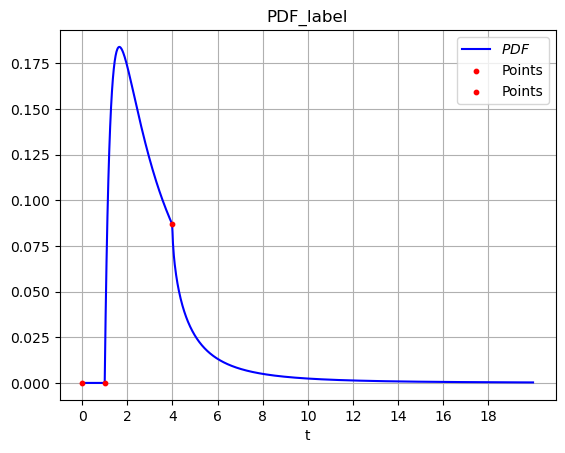

{'bottoms': ['bottom1 = 1 - 5*x'], 'points': [], 'x0': 'x0 = 4', 'y0': 'y0 = 1', 'top': 'top = 1 - 4*x', 'left': 'left = 0'}
{'x0': 4, 'y0': 1, 'top': 1 - 4*x, 'bottom1': 1 - 5*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


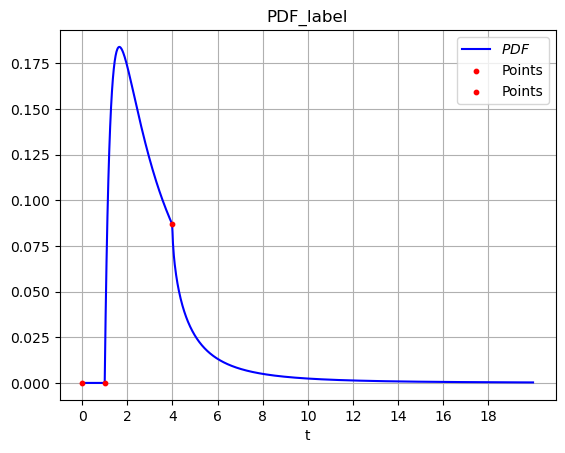

{'bottoms': ['bottom1 = 1 - 3*x'], 'points': [], 'x0': 'x0 = 2', 'y0': 'y0 = 1', 'top': 'top = 1 - 2*x', 'left': 'left = 0'}
{'x0': 2, 'y0': 1, 'top': 1 - 2*x, 'bottom1': 1 - 3*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


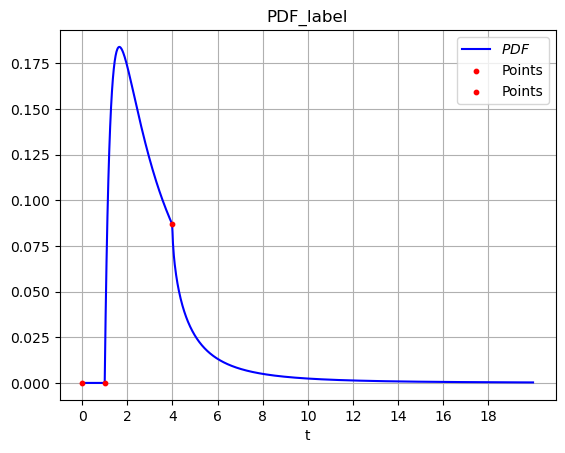

{'bottoms': ['bottom1 = 1 - 6*x'], 'points': [], 'x0': 'x0 = 5', 'y0': 'y0 = 1', 'top': 'top = 1 - 5*x', 'left': 'left = 0'}
{'x0': 5, 'y0': 1, 'top': 1 - 5*x, 'bottom1': 1 - 6*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


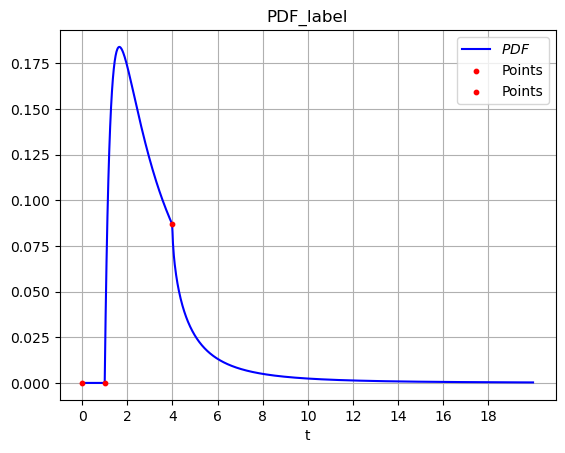

{'bottoms': ['bottom1 = 1 - 2*x'], 'points': [], 'x0': 'x0 = 1', 'y0': 'y0 = 1', 'top': 'top = 1 - x', 'left': 'left = 0'}
{'x0': 1, 'y0': 1, 'top': 1 - x, 'bottom1': 1 - 2*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


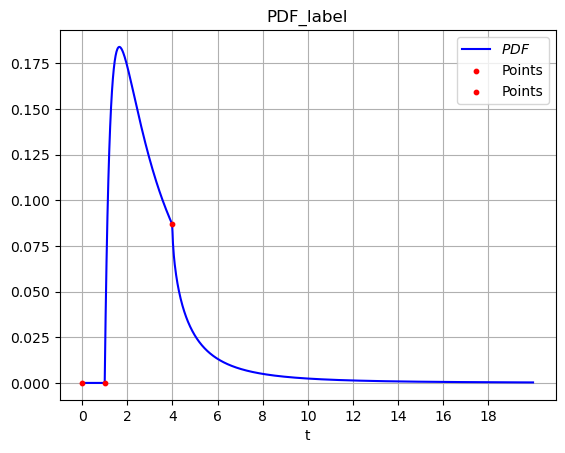

LaTeX file saved: 0
PDF successfully created: 0
section 1
{'bottoms': ['bottom1 = 1 - 3*x'], 'points': [], 'x0': 'x0 = 2', 'y0': 'y0 = 1', 'top': 'top = 1 - 2*x', 'left': 'left = 0'}
{'x0': 2, 'y0': 1, 'top': 1 - 2*x, 'bottom1': 1 - 3*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


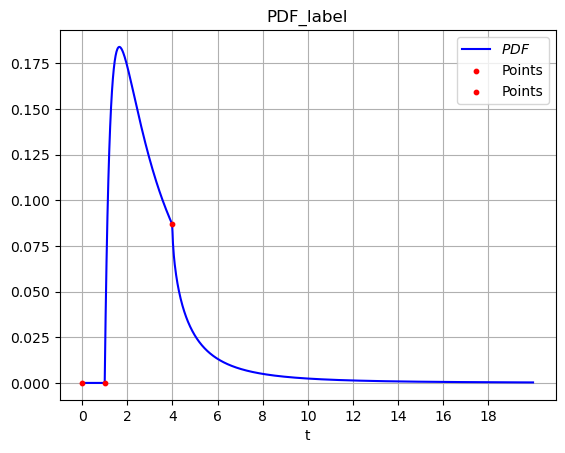

{'bottoms': ['bottom1 = 1 - 2*x'], 'points': [], 'x0': 'x0 = 1', 'y0': 'y0 = 1', 'top': 'top = 1 - x', 'left': 'left = 0'}
{'x0': 1, 'y0': 1, 'top': 1 - x, 'bottom1': 1 - 2*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


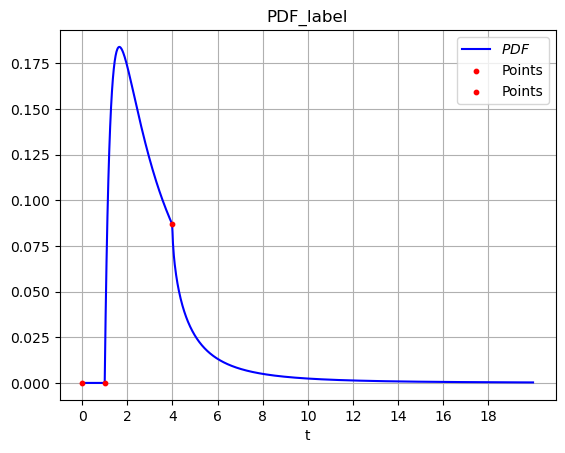

LaTeX file saved: 1
PDF successfully created: 1
section 2
{'bottoms': ['bottom1 = 1 - 5*x/2'], 'points': [], 'x0': 'x0 = 3/2', 'y0': 'y0 = 1', 'top': 'top = 1 - 3*x/2', 'left': 'left = 0'}
{'x0': 3/2, 'y0': 1, 'top': 1 - (3*x)/2, 'bottom1': 1 - (5*x)/2, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


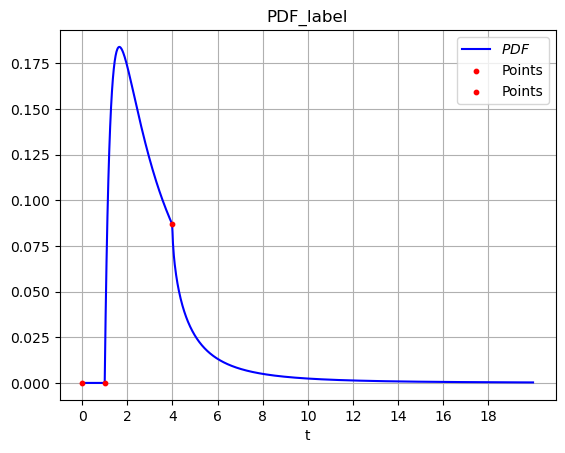

{'bottoms': ['bottom1 = 1 - 7*x/2'], 'points': [], 'x0': 'x0 = 5/2', 'y0': 'y0 = 1', 'top': 'top = 1 - 5*x/2', 'left': 'left = 0'}
{'x0': 5/2, 'y0': 1, 'top': 1 - (5*x)/2, 'bottom1': 1 - (7*x)/2, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


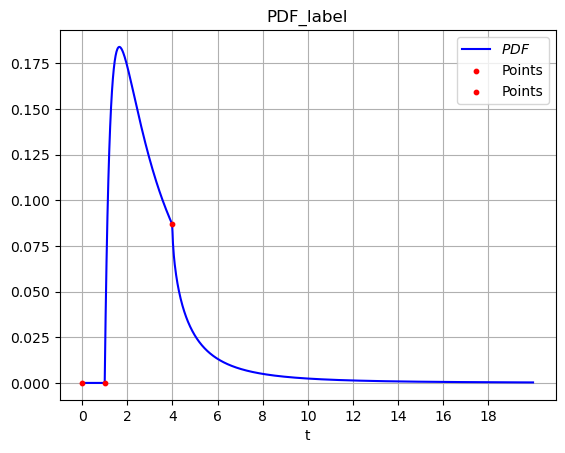

{'bottoms': ['bottom1 = 1 - 3*x/2'], 'points': [], 'x0': 'x0 = 1/2', 'y0': 'y0 = 1', 'top': 'top = 1 - x/2', 'left': 'left = 0'}
{'x0': 1/2, 'y0': 1, 'top': 1 - x/2, 'bottom1': 1 - (3*x)/2, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


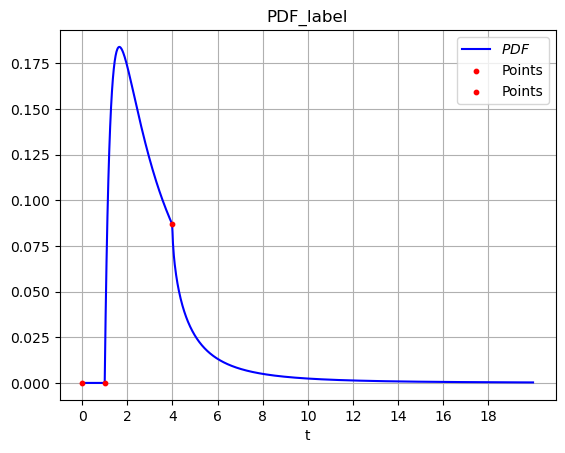

LaTeX file saved: 2
PDF successfully created: 2
section 3
{'bottoms': ['bottom1 = 1 - 17*x/3', 'bottom2 = 1/2 - 25*x/6'], 'points': ['point1 = 1/3'], 'x0': 'x0 = 11/3', 'y0': 'y0 = 1', 'top': 'top = 1 - 11*x/3', 'left': 'left = 0'}
{'x0': 11/3, 'y0': 1, 'top': 1 - (11*x)/3, 'bottom1': 1 - (17*x)/3, 'bottom2': 1/2 - (25*x)/6, 'point1': 1/3, 'point0': 0, 'point2': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1:             9
timePoint1A: None
timePoint1B: None
timeBottom1:             8
timePoint2: None
timePoint2A: None
timeBottom2:             8

[0, 'f1', 'Simplify[f1 - f010$1 - f010$2]', 'Simplify[f1 - f011$1 - f110$2]']

cs orig: [['0', '1'], ['1', '8'], ['8', '9'], ['9', 'Infinity']]
cs for graph: [['0', '1'], ['1', '8'], ['8', '9'], ['9', '20']]


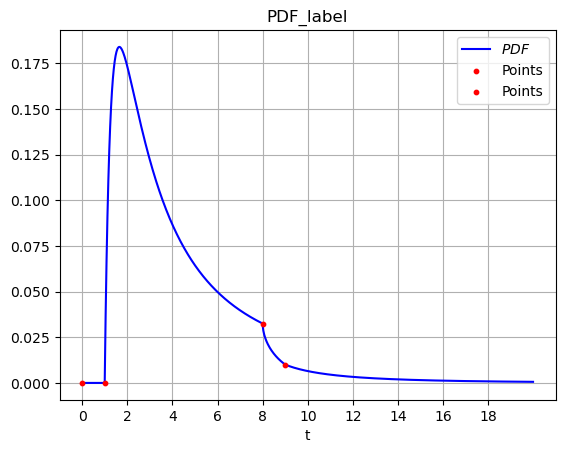

{'bottoms': ['bottom1 = 1 - 11*x/3'], 'points': [], 'x0': 'x0 = 8/3', 'y0': 'y0 = 1', 'top': 'top = 1 - 8*x/3', 'left': 'left = 0'}
{'x0': 8/3, 'y0': 1, 'top': 1 - (8*x)/3, 'bottom1': 1 - (11*x)/3, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


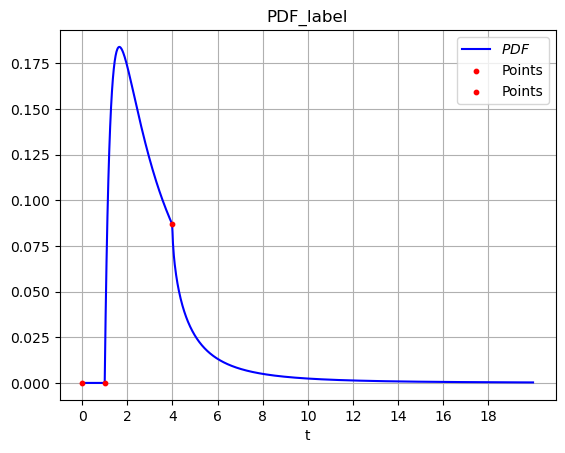

{'bottoms': ['bottom1 = 1 - 8*x/3'], 'points': [], 'x0': 'x0 = 5/3', 'y0': 'y0 = 1', 'top': 'top = 1 - 5*x/3', 'left': 'left = 0'}
{'x0': 5/3, 'y0': 1, 'top': 1 - (5*x)/3, 'bottom1': 1 - (8*x)/3, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


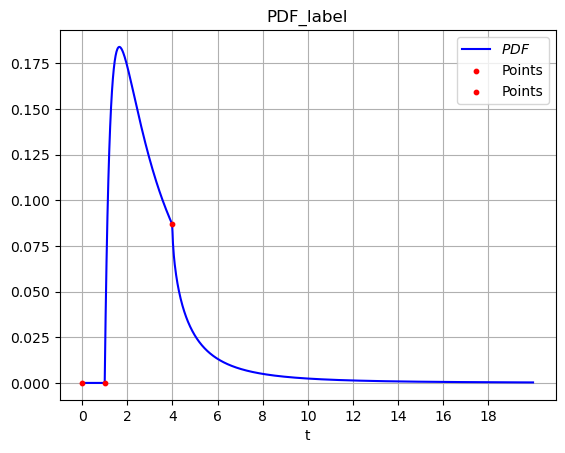

{'bottoms': ['bottom1 = 1 - 17*x/3', 'bottom2 = 1/3 - 13*x/3'], 'points': ['point1 = 1/2'], 'x0': 'x0 = 25/3', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 25*x/6', 'left': 'left = 1/3'}
{'x0': 25/3, 'y0': 2, 'top': 1/2 - (25*x)/6, 'bottom1': 1 - (17*x)/3, 'bottom2': 1/3 - (13*x)/3, 'point1': 1/2, 'point0': 1/3, 'point2': 1}
timeEnter:             2
timePoint0:             6
timePoint0A:             6
timePoint1:             8
timePoint1A: None
timePoint1B: None
timeBottom1:             6
timePoint2:             6
timePoint2A:             6
timeBottom2:             6

[0, 'f1', 'Simplify[fL - f110$1 - f011$2]', 'Simplify[fL - f111$1 - f111$2]']

cs orig: [['0', '2'], ['2', '6'], ['6', '8']]


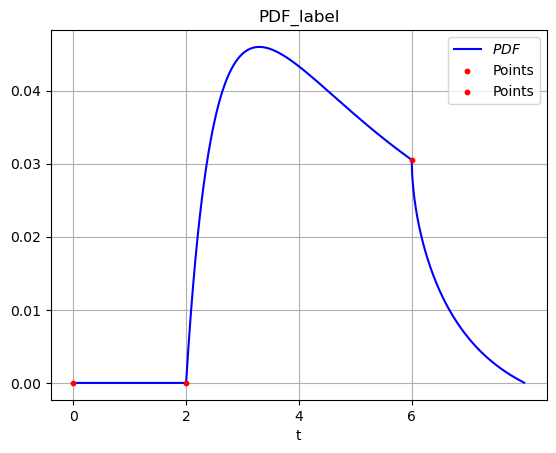

{'bottoms': ['bottom1 = 1/2 - 14*x/3'], 'points': [], 'x0': 'x0 = 13', 'y0': 'y0 = 3', 'top': 'top = 1/3 - 13*x/3', 'left': 'left = 1/2'}
{'x0': 13, 'y0': 3, 'top': 1/3 - (13*x)/3, 'bottom1': 1/2 - (14*x)/3, 'point0': 1/2, 'point1': 1}
timeEnter:             3
timePoint0:             6
timePoint0A: None
timePoint1:             6
timePoint1A: None
timeBottom1:             16
            --
            3

[0, 'f1', 'Simplify[f1 - f010$1]', 'Simplify[fL - f111$1]']

cs orig: [['0', '3'], ['3', '16/3'], ['16/3', '6']]


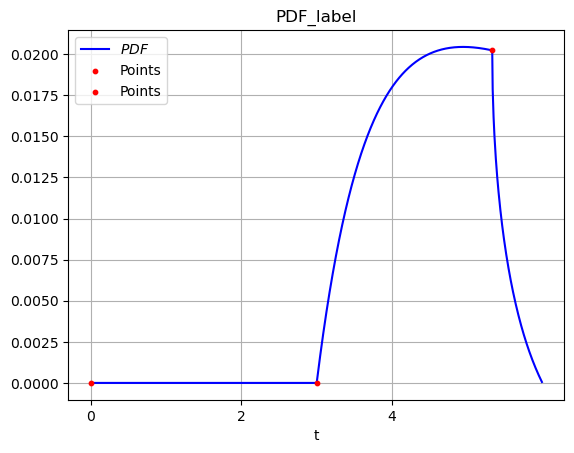

{'bottoms': ['bottom1 = 1 - 17*x/3'], 'points': [], 'x0': 'x0 = 28/3', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 14*x/3', 'left': 'left = 1/2'}
{'x0': 28/3, 'y0': 2, 'top': 1/2 - (14*x)/3, 'bottom1': 1 - (17*x)/3, 'point0': 1/2, 'point1': 1}
timeEnter:             2
timePoint0:             4
timePoint0A:             4
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[fL - f110$1]']

cs orig: [['0', '2'], ['2', '4'], ['4', 'Infinity']]
cs for graph: [['0', '2'], ['2', '4'], ['4', '20']]


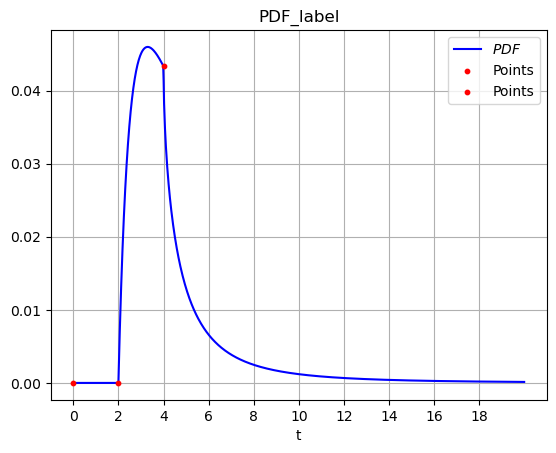

LaTeX file saved: 3
PDF successfully created: 3
section 4
{'bottoms': ['bottom1 = 1/2 - 7*x/8'], 'points': [], 'x0': 'x0 = 5/4', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 5*x/8', 'left': 'left = 0'}
{'x0': 5/4, 'y0': 2, 'top': 1/2 - (5*x)/8, 'bottom1': 1/2 - (7*x)/8, 'point0': 0, 'point1': 1}
timeEnter:             2
timePoint0: None
timePoint0A: None
timePoint1:             4
timePoint1A:             4
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f011$1]']

cs orig: [['0', '2'], ['2', '4'], ['4', 'Infinity']]
cs for graph: [['0', '2'], ['2', '4'], ['4', '20']]


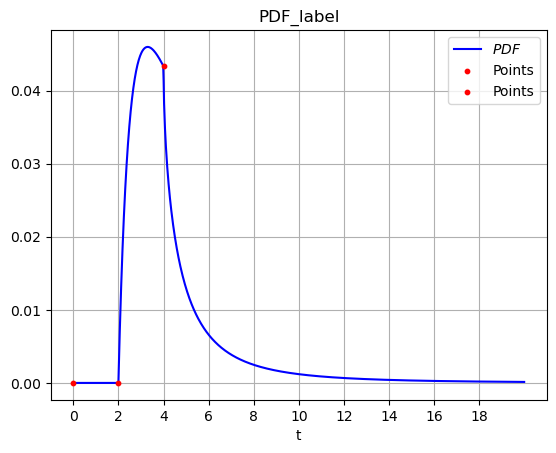

{'bottoms': ['bottom1 = 1/2 - 5*x/8'], 'points': [], 'x0': 'x0 = 3/4', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 3*x/8', 'left': 'left = 0'}
{'x0': 3/4, 'y0': 2, 'top': 1/2 - (3*x)/8, 'bottom1': 1/2 - (5*x)/8, 'point0': 0, 'point1': 1}
timeEnter:             2
timePoint0: None
timePoint0A: None
timePoint1:             4
timePoint1A:             4
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f011$1]']

cs orig: [['0', '2'], ['2', '4'], ['4', 'Infinity']]
cs for graph: [['0', '2'], ['2', '4'], ['4', '20']]


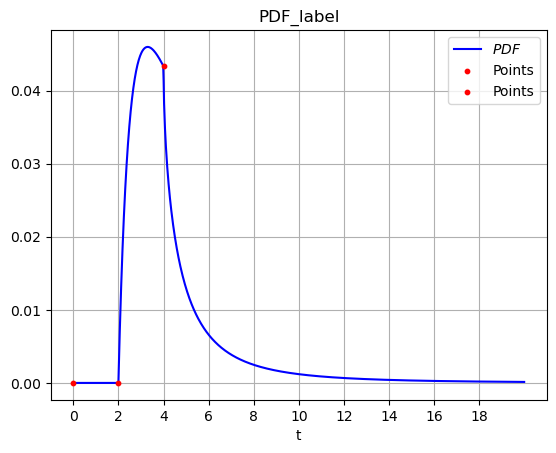

{'bottoms': ['bottom1 = 1/2 - 9*x/8'], 'points': [], 'x0': 'x0 = 7/4', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 7*x/8', 'left': 'left = 0'}
{'x0': 7/4, 'y0': 2, 'top': 1/2 - (7*x)/8, 'bottom1': 1/2 - (9*x)/8, 'point0': 0, 'point1': 1}
timeEnter:             2
timePoint0: None
timePoint0A: None
timePoint1:             4
timePoint1A:             4
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f011$1]']

cs orig: [['0', '2'], ['2', '4'], ['4', 'Infinity']]
cs for graph: [['0', '2'], ['2', '4'], ['4', '20']]


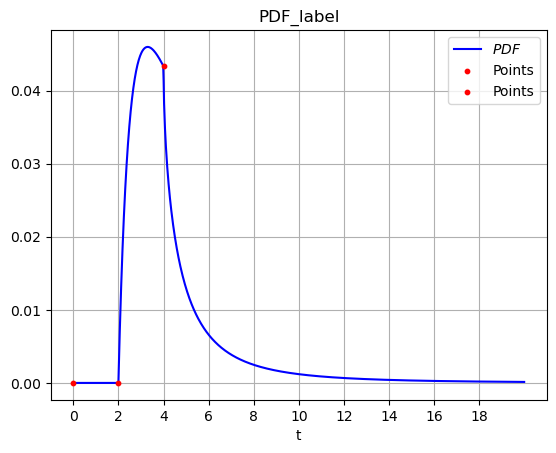

{'bottoms': ['bottom1 = 1/2 - 3*x/8'], 'points': [], 'x0': 'x0 = 1/4', 'y0': 'y0 = 2', 'top': 'top = 1/2 - x/8', 'left': 'left = 0'}
{'x0': 1/4, 'y0': 2, 'top': 1/2 - x/8, 'bottom1': 1/2 - (3*x)/8, 'point0': 0, 'point1': 1}
timeEnter:             2
timePoint0: None
timePoint0A: None
timePoint1:             4
timePoint1A:             4
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f011$1]']

cs orig: [['0', '2'], ['2', '4'], ['4', 'Infinity']]
cs for graph: [['0', '2'], ['2', '4'], ['4', '20']]


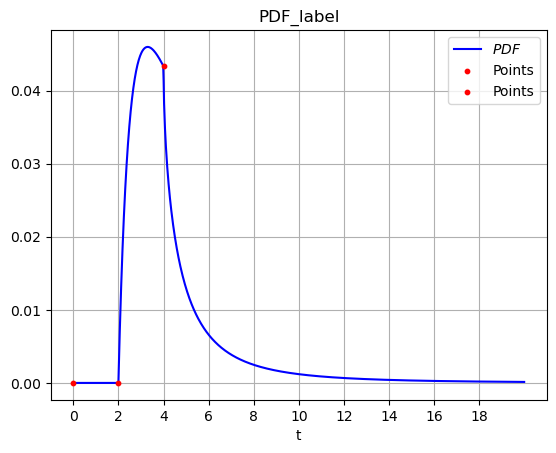

LaTeX file saved: 4
PDF successfully created: 4
section 5
{'bottoms': ['bottom1 = 1 - 6*x'], 'points': [], 'x0': 'x0 = 5', 'y0': 'y0 = 1', 'top': 'top = 1 - 5*x', 'left': 'left = 0'}
{'x0': 5, 'y0': 1, 'top': 1 - 5*x, 'bottom1': 1 - 6*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


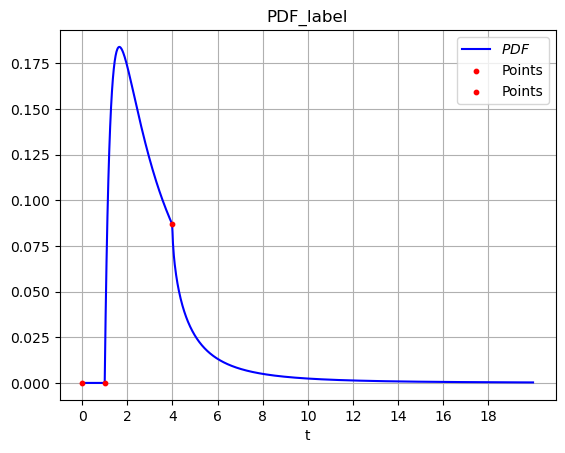

{'bottoms': ['bottom1 = 1 - 5*x', 'bottom2 = 1/2 - 7*x/2'], 'points': ['point1 = 1/3'], 'x0': 'x0 = 3', 'y0': 'y0 = 1', 'top': 'top = 1 - 3*x', 'left': 'left = 0'}
{'x0': 3, 'y0': 1, 'top': 1 - 3*x, 'bottom1': 1 - 5*x, 'bottom2': 1/2 - (7*x)/2, 'point1': 1/3, 'point0': 0, 'point2': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1:             9
timePoint1A: None
timePoint1B: None
timeBottom1:             8
timePoint2: None
timePoint2A: None
timeBottom2:             8

[0, 'f1', 'Simplify[f1 - f010$1 - f010$2]', 'Simplify[f1 - f011$1 - f110$2]']

cs orig: [['0', '1'], ['1', '8'], ['8', '9'], ['9', 'Infinity']]
cs for graph: [['0', '1'], ['1', '8'], ['8', '9'], ['9', '20']]


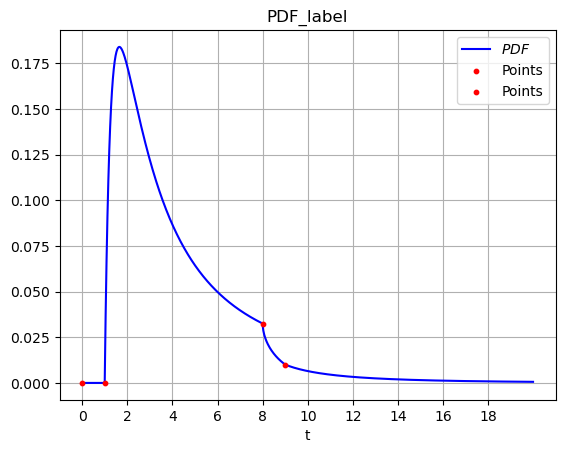

{'bottoms': ['bottom1 = 1 - 3*x'], 'points': [], 'x0': 'x0 = 2', 'y0': 'y0 = 1', 'top': 'top = 1 - 2*x', 'left': 'left = 0'}
{'x0': 2, 'y0': 1, 'top': 1 - 2*x, 'bottom1': 1 - 3*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


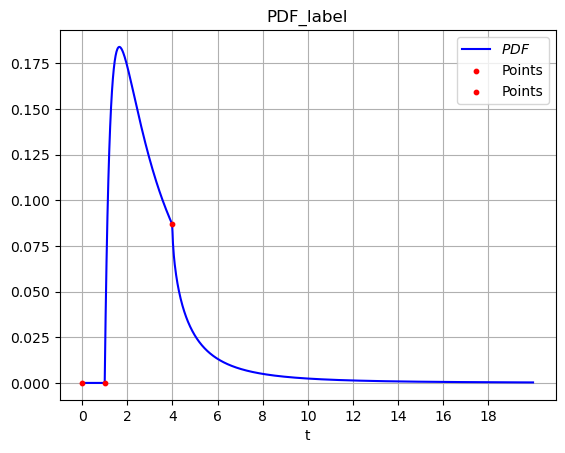

{'bottoms': ['bottom1 = 1 - 7*x'], 'points': [], 'x0': 'x0 = 6', 'y0': 'y0 = 1', 'top': 'top = 1 - 6*x', 'left': 'left = 0'}
{'x0': 6, 'y0': 1, 'top': 1 - 6*x, 'bottom1': 1 - 7*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


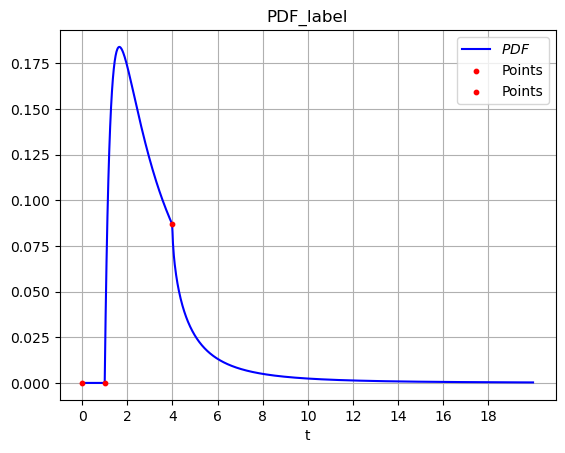

{'bottoms': ['bottom1 = 1 - 2*x'], 'points': [], 'x0': 'x0 = 1', 'y0': 'y0 = 1', 'top': 'top = 1 - x', 'left': 'left = 0'}
{'x0': 1, 'y0': 1, 'top': 1 - x, 'bottom1': 1 - 2*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


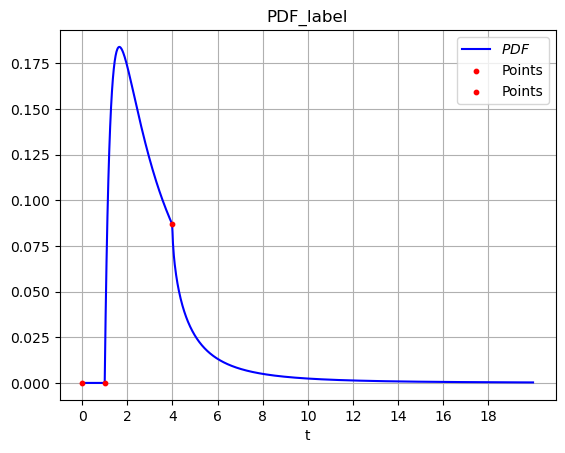

{'bottoms': ['bottom1 = 1 - 5*x', 'bottom2 = 1/3 - 11*x/3'], 'points': ['point1 = 1/2'], 'x0': 'x0 = 7', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 7*x/2', 'left': 'left = 1/3'}
{'x0': 7, 'y0': 2, 'top': 1/2 - (7*x)/2, 'bottom1': 1 - 5*x, 'bottom2': 1/3 - (11*x)/3, 'point1': 1/2, 'point0': 1/3, 'point2': 1}
timeEnter:             2
timePoint0:             6
timePoint0A:             6
timePoint1:             8
timePoint1A: None
timePoint1B: None
timeBottom1:             6
timePoint2:             6
timePoint2A:             6
timeBottom2:             6

[0, 'f1', 'Simplify[fL - f110$1 - f011$2]', 'Simplify[fL - f111$1 - f111$2]']

cs orig: [['0', '2'], ['2', '6'], ['6', '8']]


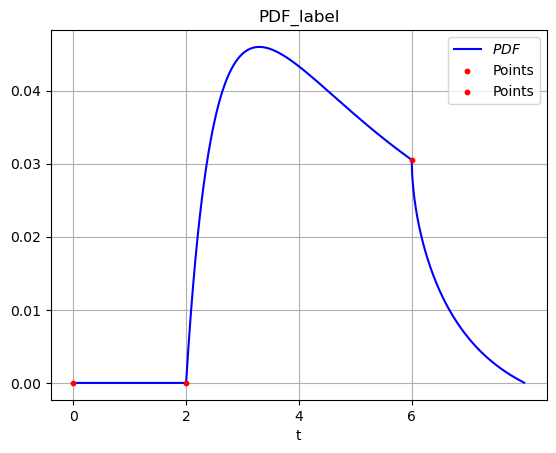

{'bottoms': ['bottom1 = 1 - 5*x'], 'points': [], 'x0': 'x0 = 8', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 4*x', 'left': 'left = 1/2'}
{'x0': 8, 'y0': 2, 'top': 1/2 - 4*x, 'bottom1': 1 - 5*x, 'point0': 1/2, 'point1': 1}
timeEnter:             2
timePoint0:             4
timePoint0A:             4
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[fL - f110$1]']

cs orig: [['0', '2'], ['2', '4'], ['4', 'Infinity']]
cs for graph: [['0', '2'], ['2', '4'], ['4', '20']]


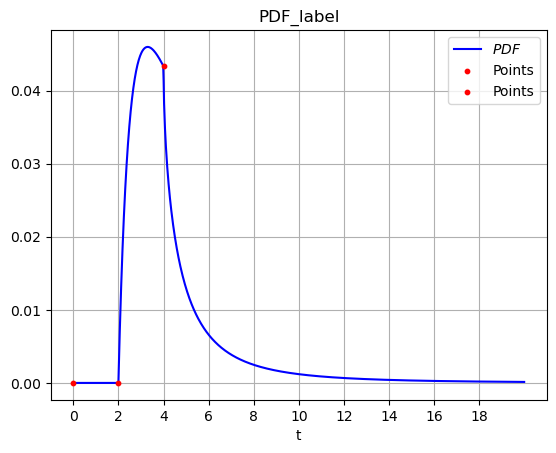

{'bottoms': ['bottom1 = 1/2 - 4*x'], 'points': [], 'x0': 'x0 = 11', 'y0': 'y0 = 3', 'top': 'top = 1/3 - 11*x/3', 'left': 'left = 1/2'}
{'x0': 11, 'y0': 3, 'top': 1/3 - (11*x)/3, 'bottom1': 1/2 - 4*x, 'point0': 1/2, 'point1': 1}
timeEnter:             3
timePoint0:             6
timePoint0A: None
timePoint1:             6
timePoint1A: None
timeBottom1:             16
            --
            3

[0, 'f1', 'Simplify[f1 - f010$1]', 'Simplify[fL - f111$1]']

cs orig: [['0', '3'], ['3', '16/3'], ['16/3', '6']]


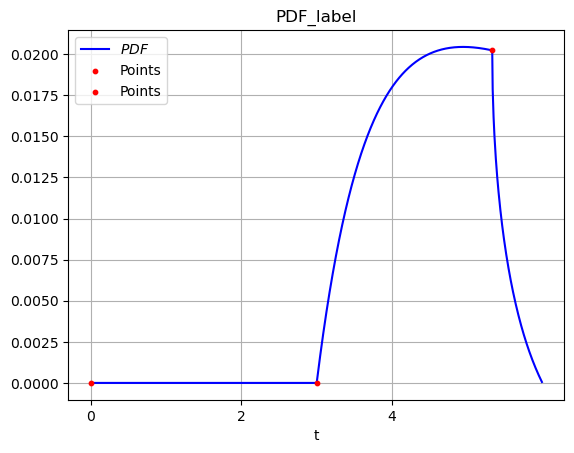

LaTeX file saved: 5
PDF successfully created: 5
section 6
{'bottoms': ['bottom1 = 1 - 6*x'], 'points': [], 'x0': 'x0 = 5', 'y0': 'y0 = 1', 'top': 'top = 1 - 5*x', 'left': 'left = 0'}
{'x0': 5, 'y0': 1, 'top': 1 - 5*x, 'bottom1': 1 - 6*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


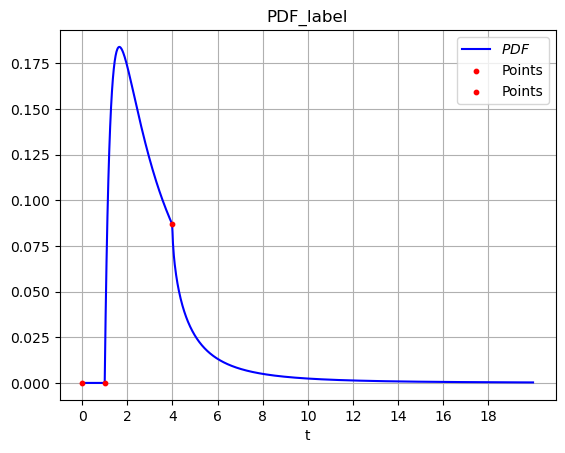

{'bottoms': ['bottom1 = 1 - 4*x'], 'points': [], 'x0': 'x0 = 3', 'y0': 'y0 = 1', 'top': 'top = 1 - 3*x', 'left': 'left = 0'}
{'x0': 3, 'y0': 1, 'top': 1 - 3*x, 'bottom1': 1 - 4*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


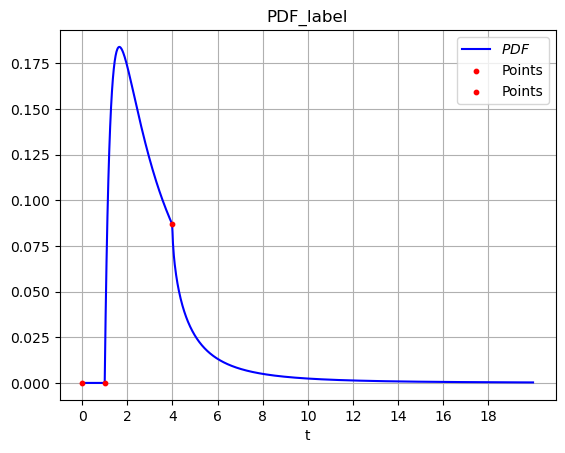

{'bottoms': ['bottom1 = 1 - 5*x'], 'points': [], 'x0': 'x0 = 4', 'y0': 'y0 = 1', 'top': 'top = 1 - 4*x', 'left': 'left = 0'}
{'x0': 4, 'y0': 1, 'top': 1 - 4*x, 'bottom1': 1 - 5*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


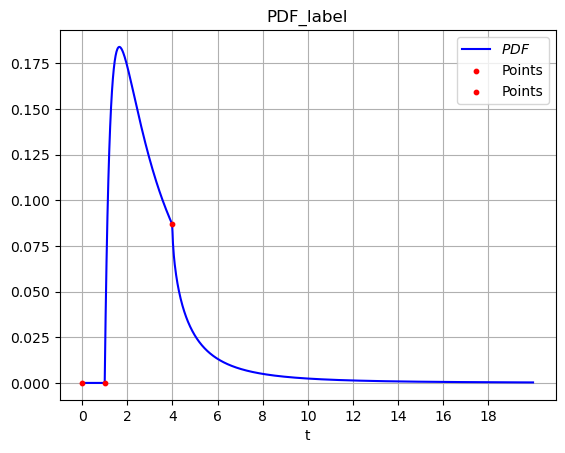

{'bottoms': ['bottom1 = 1 - 3*x', 'bottom2 = 1/2 - 3*x/2'], 'points': ['point1 = 1/3'], 'x0': 'x0 = 1', 'y0': 'y0 = 1', 'top': 'top = 1 - x', 'left': 'left = 0'}
{'x0': 1, 'y0': 1, 'top': 1 - x, 'bottom1': 1 - 3*x, 'bottom2': 1/2 - (3*x)/2, 'point1': 1/3, 'point0': 0, 'point2': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1:             9
timePoint1A: None
timePoint1B: None
timeBottom1:             8
timePoint2: None
timePoint2A: None
timeBottom2:             8

[0, 'f1', 'Simplify[f1 - f010$1 - f010$2]', 'Simplify[f1 - f011$1 - f110$2]']

cs orig: [['0', '1'], ['1', '8'], ['8', '9'], ['9', 'Infinity']]
cs for graph: [['0', '1'], ['1', '8'], ['8', '9'], ['9', '20']]


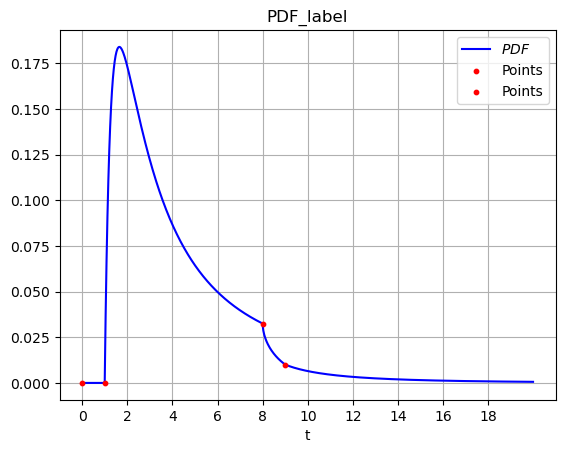

{'bottoms': ['bottom1 = 1 - 7*x'], 'points': [], 'x0': 'x0 = 6', 'y0': 'y0 = 1', 'top': 'top = 1 - 6*x', 'left': 'left = 0'}
{'x0': 6, 'y0': 1, 'top': 1 - 6*x, 'bottom1': 1 - 7*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


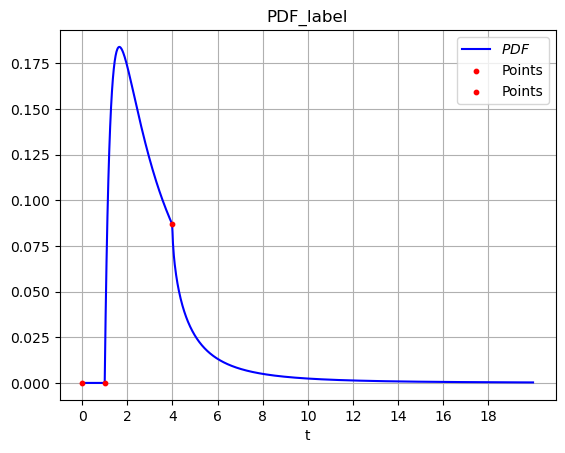

{'bottoms': ['bottom1 = 1 - 3*x', 'bottom2 = 1/3 - 5*x/3'], 'points': ['point1 = 1/2'], 'x0': 'x0 = 3', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 3*x/2', 'left': 'left = 1/3'}
{'x0': 3, 'y0': 2, 'top': 1/2 - (3*x)/2, 'bottom1': 1 - 3*x, 'bottom2': 1/3 - (5*x)/3, 'point1': 1/2, 'point0': 1/3, 'point2': 1}
timeEnter:             2
timePoint0:             6
timePoint0A:             6
timePoint1:             8
timePoint1A: None
timePoint1B: None
timeBottom1:             6
timePoint2:             6
timePoint2A:             6
timeBottom2:             6

[0, 'f1', 'Simplify[fL - f110$1 - f011$2]', 'Simplify[fL - f111$1 - f111$2]']

cs orig: [['0', '2'], ['2', '6'], ['6', '8']]


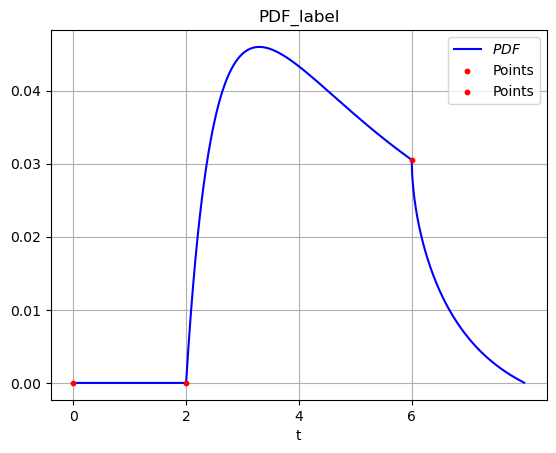

{'bottoms': ['bottom1 = 1 - 3*x'], 'points': [], 'x0': 'x0 = 4', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 2*x', 'left': 'left = 1/2'}
{'x0': 4, 'y0': 2, 'top': 1/2 - 2*x, 'bottom1': 1 - 3*x, 'point0': 1/2, 'point1': 1}
timeEnter:             2
timePoint0:             4
timePoint0A:             4
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[fL - f110$1]']

cs orig: [['0', '2'], ['2', '4'], ['4', 'Infinity']]
cs for graph: [['0', '2'], ['2', '4'], ['4', '20']]


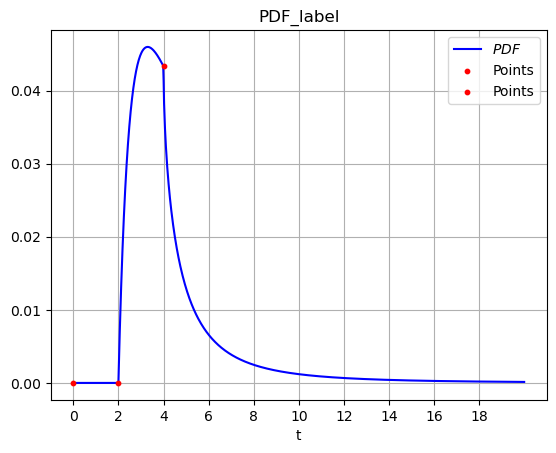

{'bottoms': ['bottom1 = 1/2 - 2*x'], 'points': [], 'x0': 'x0 = 5', 'y0': 'y0 = 3', 'top': 'top = 1/3 - 5*x/3', 'left': 'left = 1/2'}
{'x0': 5, 'y0': 3, 'top': 1/3 - (5*x)/3, 'bottom1': 1/2 - 2*x, 'point0': 1/2, 'point1': 1}
timeEnter:             3
timePoint0:             6
timePoint0A: None
timePoint1:             6
timePoint1A: None
timeBottom1:             16
            --
            3

[0, 'f1', 'Simplify[f1 - f010$1]', 'Simplify[fL - f111$1]']

cs orig: [['0', '3'], ['3', '16/3'], ['16/3', '6']]


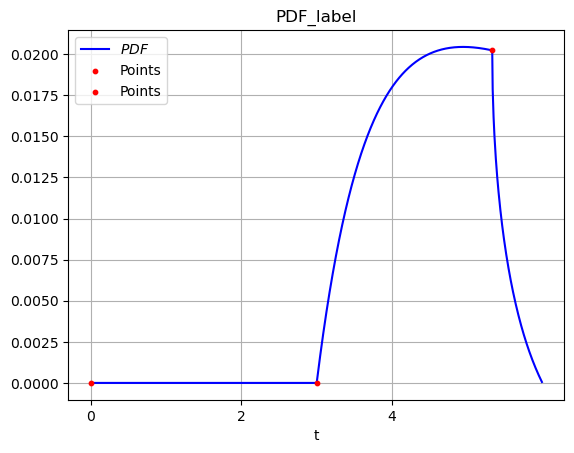

LaTeX file saved: 6
PDF successfully created: 6
section 7
{'bottoms': ['bottom1 = 1 - 6*x'], 'points': [], 'x0': 'x0 = 5', 'y0': 'y0 = 1', 'top': 'top = 1 - 5*x', 'left': 'left = 0'}
{'x0': 5, 'y0': 1, 'top': 1 - 5*x, 'bottom1': 1 - 6*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


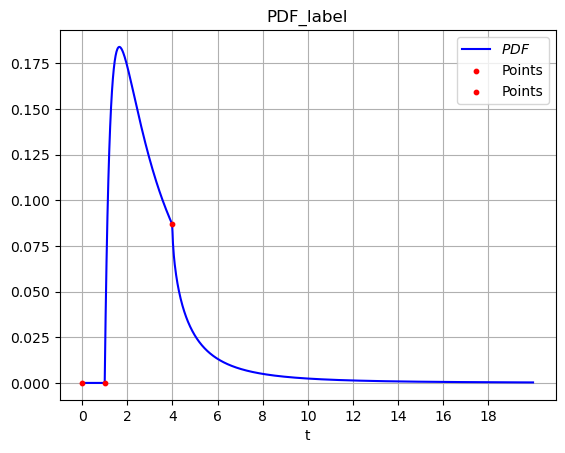

{'bottoms': ['bottom1 = 1 - 5*x', 'bottom2 = 1/2 - 7*x/2'], 'points': ['point1 = 1/3'], 'x0': 'x0 = 3', 'y0': 'y0 = 1', 'top': 'top = 1 - 3*x', 'left': 'left = 0'}
{'x0': 3, 'y0': 1, 'top': 1 - 3*x, 'bottom1': 1 - 5*x, 'bottom2': 1/2 - (7*x)/2, 'point1': 1/3, 'point0': 0, 'point2': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1:             9
timePoint1A: None
timePoint1B: None
timeBottom1:             8
timePoint2: None
timePoint2A: None
timeBottom2:             8

[0, 'f1', 'Simplify[f1 - f010$1 - f010$2]', 'Simplify[f1 - f011$1 - f110$2]']

cs orig: [['0', '1'], ['1', '8'], ['8', '9'], ['9', 'Infinity']]
cs for graph: [['0', '1'], ['1', '8'], ['8', '9'], ['9', '20']]


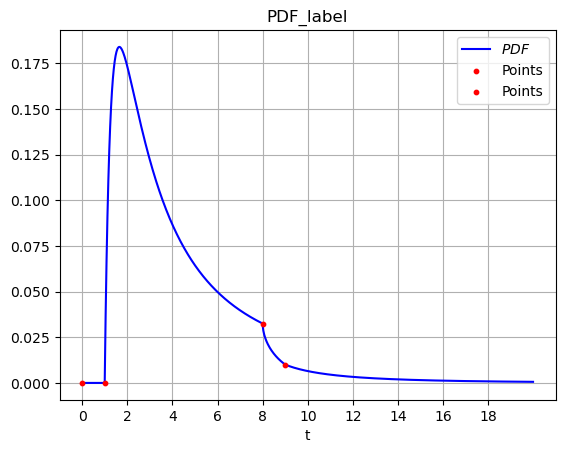

{'bottoms': ['bottom1 = 1 - 3*x'], 'points': [], 'x0': 'x0 = 2', 'y0': 'y0 = 1', 'top': 'top = 1 - 2*x', 'left': 'left = 0'}
{'x0': 2, 'y0': 1, 'top': 1 - 2*x, 'bottom1': 1 - 3*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


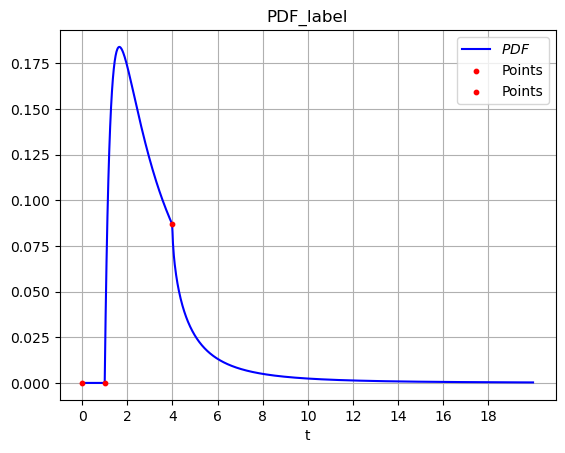

{'bottoms': ['bottom1 = 1 - 7*x'], 'points': [], 'x0': 'x0 = 6', 'y0': 'y0 = 1', 'top': 'top = 1 - 6*x', 'left': 'left = 0'}
{'x0': 6, 'y0': 1, 'top': 1 - 6*x, 'bottom1': 1 - 7*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


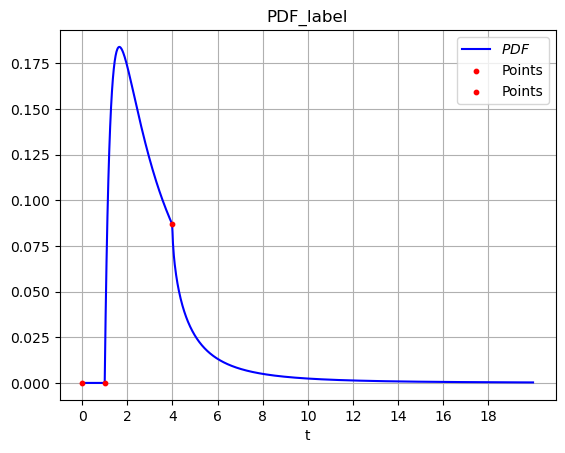

{'bottoms': ['bottom1 = 1 - 2*x'], 'points': [], 'x0': 'x0 = 1', 'y0': 'y0 = 1', 'top': 'top = 1 - x', 'left': 'left = 0'}
{'x0': 1, 'y0': 1, 'top': 1 - x, 'bottom1': 1 - 2*x, 'point0': 0, 'point1': 1}
timeEnter:             1
timePoint0: None
timePoint0A: None
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[f1 - f010$1]']

cs orig: [['0', '1'], ['1', '4'], ['4', 'Infinity']]
cs for graph: [['0', '1'], ['1', '4'], ['4', '20']]


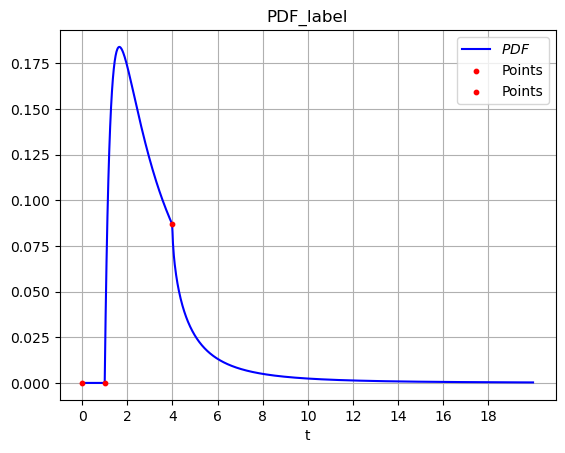

{'bottoms': ['bottom1 = 1 - 5*x', 'bottom2 = 1/3 - 11*x/3'], 'points': ['point1 = 1/2'], 'x0': 'x0 = 7', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 7*x/2', 'left': 'left = 1/3'}
{'x0': 7, 'y0': 2, 'top': 1/2 - (7*x)/2, 'bottom1': 1 - 5*x, 'bottom2': 1/3 - (11*x)/3, 'point1': 1/2, 'point0': 1/3, 'point2': 1}
timeEnter:             2
timePoint0:             6
timePoint0A:             6
timePoint1:             8
timePoint1A: None
timePoint1B: None
timeBottom1:             6
timePoint2:             6
timePoint2A:             6
timeBottom2:             6

[0, 'f1', 'Simplify[fL - f110$1 - f011$2]', 'Simplify[fL - f111$1 - f111$2]']

cs orig: [['0', '2'], ['2', '6'], ['6', '8']]


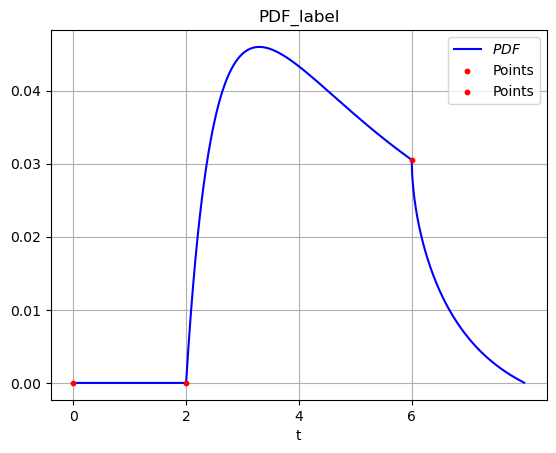

{'bottoms': ['bottom1 = 1 - 5*x'], 'points': [], 'x0': 'x0 = 8', 'y0': 'y0 = 2', 'top': 'top = 1/2 - 4*x', 'left': 'left = 1/2'}
{'x0': 8, 'y0': 2, 'top': 1/2 - 4*x, 'bottom1': 1 - 5*x, 'point0': 1/2, 'point1': 1}
timeEnter:             2
timePoint0:             4
timePoint0A:             4
timePoint1: None
timePoint1A: None
timeBottom1:             4

[0, 'f1', 'Simplify[fL - f110$1]']

cs orig: [['0', '2'], ['2', '4'], ['4', 'Infinity']]
cs for graph: [['0', '2'], ['2', '4'], ['4', '20']]


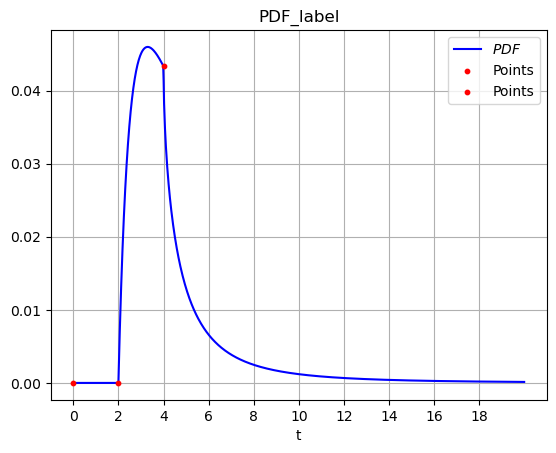

{'bottoms': ['bottom1 = 1/2 - 4*x'], 'points': [], 'x0': 'x0 = 11', 'y0': 'y0 = 3', 'top': 'top = 1/3 - 11*x/3', 'left': 'left = 1/2'}
{'x0': 11, 'y0': 3, 'top': 1/3 - (11*x)/3, 'bottom1': 1/2 - 4*x, 'point0': 1/2, 'point1': 1}
timeEnter:             3
timePoint0:             6
timePoint0A: None
timePoint1:             6
timePoint1A: None
timeBottom1:             16
            --
            3

[0, 'f1', 'Simplify[f1 - f010$1]', 'Simplify[fL - f111$1]']

cs orig: [['0', '3'], ['3', '16/3'], ['16/3', '6']]


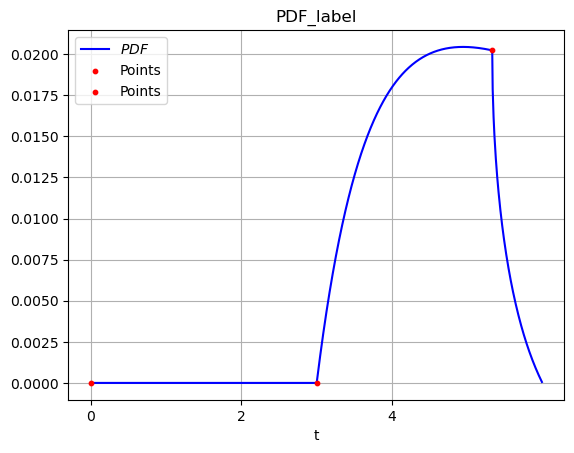

LaTeX file saved: 7
PDF successfully created: 7
0 1
1 2
2 3
3 4
4 16/3
16/3 6
6 8
8 9
9 Infinity


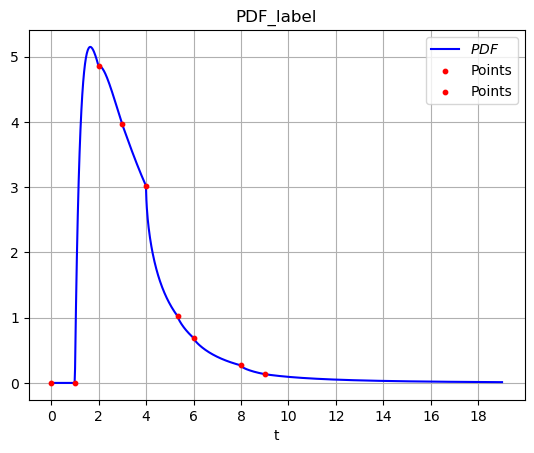

PDF successfully created: results/6 - 10/test_final_eq.pdf


NameError: name 't0' is not defined

<Figure size 640x480 with 0 Axes>

In [65]:
list_piecewise, boundary_points = run_integrals(n_squares, index, a, perm)
# Create the combined Piecewise function
combined_pw, combined_scaled_pw = create_combined_piecewise(list_piecewise, boundary_points)

# Print the result
latex_expr = sp.latex(combined_pw)
latex_expr = latex_expr.replace(r"\text{for}\: t", "").replace(r"\geq", "").replace(r"\wedge", r"\leq")

# create boundary pairs for graphing - replace infinity with the previous condition + 10
interval_list = [[boundary_points[i], boundary_points[i + 1]] for i in range(len(boundary_points) - 1)]
interval_list[-1][1] = interval_list[-1][0] + 10

graph_piece(combined_pw, interval_list, n_squares, index, -1, 50)

final_dir = os.path.join("results", f"{n_squares} - {index}")
os.makedirs(final_dir, exist_ok=True)  # Ensure directory exists

with open(os.path.join(final_dir, f"test_final_eq.dill"), 'wb') as file:
    dill.dump(combined_pw, file)

with open(os.path.join(final_dir, f"test_final_scaled_eq.dill"), 'wb') as file:
    dill.dump(combined_scaled_pw, file)

latex_file_path = os.path.join(final_dir, f"test_final_eq.tex")
pdf_file_path = os.path.join(final_dir, f"test_final_eq.pdf")

# Write LaTeX file
with open(latex_file_path, "w") as latex_file:
    
    latex_file.write("\\documentclass{article}\n")
    latex_file.write("\\usepackage{amsmath}\n")
    latex_file.write("\\usepackage[paperheight=11in,paperwidth=60in]{geometry}\n")
    latex_file.write("\\begin{document}\n\n")
    latex_file.write(f"Equation:\n\\[\n{latex_expr}\n\\]\n\n")
    latex_file.write("\\end{document}\n")

# Compile LaTeX file and delete intermediate files
try:
    with open(os.devnull, "w") as FNULL:
        subprocess.run(
            ["pdflatex", "-output-directory", final_dir, latex_file_path],
            stdout=FNULL, stderr=FNULL, check=True
        )

    print(f"PDF successfully created: {pdf_file_path}")

    # Remove auxiliary files (.log, .aux)
    for ext in [".log", ".aux"]:
        aux_file = os.path.join(final_dir, f"test_final_eq{ext}")
        if os.path.exists(aux_file):
            os.remove(aux_file)

except subprocess.CalledProcessError:
    print(f"Error: Failed to compile {latex_file_path} into a PDF.")

t1 = time()
print(f"integrals done: {(t1-t0)/60**2}\n")
print("-----------------------------------------------------------------------------------")

In [7]:
from matplotlib import pyplot as plt
import os
from Library import *
from time import time
import dill
import re
import subprocess
import numpy as np
M = mathematica
from IPython.display import display, Math
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
from sympy import symbols, And, Piecewise, Add, N
from sympy.core.relational import Relational
from integration_functions import *
from fractions import Fraction as frac

n_squares = 6
index = 20
trouble = []
for i in range(8):
    j = 0
    while True:     
        try:
            with open(os.path.join("results", f"{n_squares} - {index}", f"cusp - {i}", f"equation_{j}.dill"), 'rb') as f:
                eq = dill.load(f)
        except:
            print(f"no function for old {i}, {j}")
        try:
            with open(os.path.join("results", f"{n_squares}_{index}", f"cusp_{i}", f"equation_{j}.dill"), 'rb') as f:
                eq2 = dill.load(f)
        except:
            print(f"no function for new {i}, {j}")
            break
        print(f"test if equation i = {i}, j = {j} are equal: {eq == eq2}")
        if eq != eq2:
            trouble.append([i,j])
        j += 1

test if equation i = 0, j = 0 are equal: True
test if equation i = 0, j = 1 are equal: True
test if equation i = 0, j = 2 are equal: True
test if equation i = 0, j = 3 are equal: True
test if equation i = 0, j = 4 are equal: True
test if equation i = 0, j = 5 are equal: True
test if equation i = 0, j = 6 are equal: True
test if equation i = 0, j = 7 are equal: True
no function for old 0, 8
no function for new 0, 8
test if equation i = 1, j = 0 are equal: True
test if equation i = 1, j = 1 are equal: True
no function for old 1, 2
no function for new 1, 2
test if equation i = 2, j = 0 are equal: True
test if equation i = 2, j = 1 are equal: True
test if equation i = 2, j = 2 are equal: True
no function for old 2, 3
no function for new 2, 3
test if equation i = 3, j = 0 are equal: True
test if equation i = 3, j = 1 are equal: True
test if equation i = 3, j = 2 are equal: True
test if equation i = 3, j = 3 are equal: True
test if equation i = 3, j = 4 are equal: True
test if equation i = 3

In [67]:
with open(os.path.join("results", f"{n_squares} - {index}", f"final_eq.dill"), 'rb') as f:
    eq = dill.load(f)
with open(os.path.join("results", f"{n_squares} - {index}", f"test_final_eq.dill"), 'rb') as f:
    eq2 = dill.load(f)
eq == eq2

True

In [28]:
eq2

Piecewise((0, (t >= 0) & (t < 1)), (-log(1/t)/t**2, (t >= 1) & (t < 4)), (-log(1/t)/t**2 - 2*atanh(sqrt((t - 4)/t))/t**2, (t >= 4) & (Infinity > t)))